In [1]:
import partialRegionBDT
import pickle
import uproot
import os
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import math as mth
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from hist import Hist
import hist
from scipy import stats
import random

Function to split input dataset into xgb DMatrices for test and train. Currently sets test size to 1/7 of train size. Needs to split the event weight and label features from the dataset and input them separately into the DMAtrix. This is done via two different methods - manual removal and the sklearn train_test_split function. Needs to output the weights as well, as train_test_split re-orders the lists and the corresponding weights need to be returned as well as the matrices.

In [2]:
def makeTestTrain(inputs,features):
   x = inputs.loc[:, features].values
   y = inputs.loc[:, ['label']].values
   masses = inputs.loc[:, ['massPoint']].values
   train_input, test_input, train_lbl, test_lbl, train_masses, test_masses = train_test_split(x, y, masses, test_size=1/2.)#, random_state=0)
   train_input_withLabel = np.concatenate((train_input, train_lbl), axis=1)  
   signalWeights=0
   backgroundWeights=0
   for x in train_input_withLabel:
        if x[len(x)-1] == 1:
            signalWeights+=x[len(x)-2]
        elif x[len(x)-1] == 0:
            backgroundWeights+=x[len(x)-2]
   shortfeat = features[0:len(features)-1]
    
   trainWeights = train_input[:,train_input.shape[1]-1]
   testWeights = test_input[:,test_input.shape[1]-1]
   train_input = np.delete(train_input,train_input.shape[1]-1,1)
   test_input = np.delete(test_input,test_input.shape[1]-1,1)
   dtrain = xgb.DMatrix(train_input,label=train_lbl,feature_names=shortfeat,weight=trainWeights)
   dtest = xgb.DMatrix(test_input,label=test_lbl,feature_names=shortfeat,weight=testWeights)
   return dtrain, dtest, trainWeights, testWeights, backgroundWeights/signalWeights, test_input, test_masses

Function that splits data into an array of training features, an array of labels, and an array mass values. Allows the training features to be used independently with the BDT from the labels and mass values

In [3]:
def format_data(inputs,features):
   trainingFeatures = inputs.loc[:, features].values
   labels = inputs.loc[:, ['label']].values
   signalMasses = inputs.loc[:, ['massPoint']].values   
   return trainingFeatures, labels, signalMasses

In [4]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


Function that defines the negative mean squared weighted error as a loss function

In [5]:
def neg_mean_squared_weighted_error(y_true,y_pred,weights):
    weightedSum = 0
    totalWeights = 0
    for i in range(0, len(y_true)):
        weightedSum = weightedSum + weights[i]*(y_true[i] - y_pred[i])**2
        totalWeights = totalWeights + weights[i]
    
    return (-1*weightedSum)/totalWeights

Function that trains different number of BDTs (currently 30), where the BDT parameters are randomly selected and the best 
set is determined to be the optimal

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import SCORERS
from sklearn.metrics import make_scorer

def optimize_hyper_xg(inData,variables,njobs):
    x,y,masses = format_data(inData,variables)
    train_input, test_input, train_lbl, test_lbl, train_masses, test_masses = train_test_split(x, y, masses, test_size=0.2, random_state=0)
    train_input_withLabel = np.concatenate((train_input, train_lbl), axis=1)  
    signalWeights=0
    backgroundWeights=0
    for x in train_input_withLabel:
        if x[len(x)-1] == 1:
            signalWeights+=x[len(x)-2]
        elif x[len(x)-1] == 0:
            backgroundWeights+=x[len(x)-2]
    print(variables)
    shortfeat = variables[0:len(variables)-1]
    print(shortfeat)
    print(len(shortfeat))

    trainWeights = train_input[:,train_input.shape[1]-1]
    testWeights = test_input[:,test_input.shape[1]-1]
    train_input = np.delete(train_input,train_input.shape[1]-1,1)
    test_input = np.delete(test_input,test_input.shape[1]-1,1)            
    dtrain = xgb.DMatrix(train_input,label=train_lbl,feature_names=shortfeat,weight=trainWeights)
    dtest = xgb.DMatrix(test_input,label=test_lbl,feature_names=shortfeat,weight=testWeights)
    
    trainWeights_scaled = trainWeights.copy()
    for idx, label in enumerate(train_lbl):
        if label == 1:
            trainWeights_scaled[idx] = trainWeights_scaled[idx]*0.0013*(backgroundWeights/signalWeights)
    params = {'weights':trainWeights_scaled}
    neg_mean_squared_weighted_error_scorer = make_scorer(neg_mean_squared_weighted_error, greater_is_better=True, **params)
        
    fixedParams = {'objective':'binary:logistic', 'booster':'gbtree'}
    bdt = xgb.XGBRegressor(objective='binary:logistic',booster='gbtree',eval_metric='logloss',scale_pos_weight=0.0013*(backgroundWeights/signalWeights))
    params = {
       "reg_alpha": stats.uniform(0,2),
       "reg_lambda": stats.uniform(0,8),
       "min_child_weight": stats.uniform(0,2),
       "colsample_bytree": stats.uniform(0.1,0.9),
        "gamma": stats.uniform(0, 0.3),
        "learning_rate": stats.uniform(0.2, 1), #stats.uniform(0, 1),
        "max_depth": stats.randint(2, 6),
        "n_estimators": stats.randint(60, 400),
        "subsample": stats.uniform(0.5,0.5),
    }
    print(SCORERS.keys())
#    search = RandomizedSearchCV(bdt, param_distributions=params, scoring = 'neg_mean_squared_error',n_iter=30, cv=5, verbose=1, n_jobs=njobs, return_train_score=False)
    search = RandomizedSearchCV(bdt, param_distributions=params, scoring =neg_mean_squared_weighted_error_scorer,n_iter=30, cv=5, verbose=1, n_jobs=njobs, return_train_score=False)
    print(len(train_input[:,0:len(variables)-1]))
    print(len(variables)-1)
    print(search)
    out = search.fit(train_input[:,0:len(variables)-1],train_lbl,sample_weight=trainWeights)
    print("Best parameter set found on development set:")
    print("")
    print(out.best_estimator_)
    print(out.best_params_)
    print("BEST roc_auc")
    print(out.best_score_)
    return out.best_estimator_, out.best_params_, dtrain, dtest, trainWeights, testWeights, backgroundWeights/signalWeights, train_input, test_input, test_masses

Function that splits the input data into nFolds that are used for training and testing. A number (nFolds) of BDTs are also created and
trained using the training data. The function returns 2D arrays of the traing, testing, and BDTs.

In [7]:
from xgboost import cv
from sklearn.model_selection import KFold

def kFoldCrossValidation(BDTparams,inData,variables,nFolds,inData_systWeights):
    x,y,masses = format_data(inData,variables)
    
    random.seed()
    seed = random.randrange(1, 10000, 1)
    seed = 111
    
    kf = KFold(n_splits=nFolds,shuffle=True,random_state=seed)
    array_train_input = []
    array_test_input = []
    array_test_input_systWeights = []
    array_train_lbl = []
    array_test_lbl = []
    array_train_weight = []
    array_test_weight = []
    array_masses = []
    array_dtrain = []
    array_dtest = []
    array_bdt =[]
    idx=0
    print(BDTparams)
    for train_index, test_index in kf.split(x):
        print("TRAIN:", train_index, "TEST:", test_index)
        array_train_input.append(x[train_index])
        array_test_input.append(x[test_index])
        array_test_input_systWeights.append(inData_systWeights.iloc[test_index])
        array_train_lbl.append(y[train_index])
        array_test_lbl.append(y[test_index])        
        array_masses.append(masses[test_index])        
        #train_input, test_input, train_lbl, test_lbl = x[train_index], x[test_index], y[train_index], y[test_index]
        train_input_withLabel = np.concatenate((array_train_input[idx], array_train_lbl[idx]), axis=1)  
        signalWeights=0
        backgroundWeights=0
        for i in train_input_withLabel:
            if i[len(i)-1] == 1:
                signalWeights+=i[len(i)-2]
            elif i[len(i)-1] == 0:
                backgroundWeights+=i[len(i)-2]
        print(variables)
        shortfeat = variables[0:len(variables)-1]
        print(shortfeat)
        print(len(shortfeat))
        BDTparams['scale_pos_weight']=0.0013*(backgroundWeights/signalWeights)

        array_train_weight.append(array_train_input[idx][:,array_train_input[idx].shape[1]-1])
        array_test_weight.append(array_test_input[idx][:,array_test_input[idx].shape[1]-1])
        array_train_input[idx] = np.delete(array_train_input[idx],array_train_input[idx].shape[1]-1,1)
        array_test_input[idx] = np.delete(array_test_input[idx],array_test_input[idx].shape[1]-1,1)            
        array_dtrain.append(xgb.DMatrix(array_train_input[idx],label=array_train_lbl[idx],feature_names=shortfeat,weight=array_train_weight[idx]))
        array_dtest.append(xgb.DMatrix(array_test_input[idx],label=array_test_lbl[idx],feature_names=shortfeat,weight=array_test_weight[idx]))
        #evallist = [(dtest,'eval'),(dtrain,'train')]
        #bst = xgb.train(BDTparams, dtrain,50,evallist)
        array_bdt.append(xgb.XGBRegressor(objective='binary:logistic',booster='gbtree',eval_metric='logloss'))
        print(BDTparams)
        array_bdt[idx].set_params(**BDTparams)
        print(array_bdt[idx].get_params())
        print(len(array_test_input[idx][:,0:len(variables)-1]))
        print(len(array_test_lbl[idx]))
        eval_set = [(array_test_input[idx][:,0:len(variables)-1],array_test_lbl[idx])]
        array_bdt[idx].fit(array_train_input[idx][:,0:len(variables)-1],array_train_lbl[idx],sample_weight=array_train_weight[idx],eval_set=eval_set)
        idx = idx+1
        
    return array_bdt, array_dtrain, array_dtest, array_train_input, array_test_input, array_train_lbl, array_test_lbl, array_train_weight, array_test_weight, array_masses, array_test_input_systWeights

Function that combines the various arrays from the kFold validation

In [8]:
def combiningKFolds(aBDT,aTest,aTest_array,aTestWeight,aTestMasses,aTrain,aTrain_array,aTrainWeight,nFolds, systWeights_array):
  array_y_predsAltTrain = []
  array_labelsaltTrain = []
  array_y_predsAlt = []
  array_labelsalt = []    
  all_y_predsAlt = np.array([])
  all_labelsalt = np.array([])
  all_systWeights = pd.concat(systWeights_array)
  all_aTestWeight = np.array([])
  all_aTestMasses = np.concatenate(np.concatenate( aTestMasses, axis=0 ), axis=0)
  #allTest_events = np.array([])
  allTest_events = []
    
  for idx in range(0,nFolds):
    print("Inside combiningKFolds")
    y_predsAlt = aBDT[idx].predict(aTest_array[idx])
    all_y_predsAlt = np.concatenate([all_y_predsAlt,y_predsAlt])
    all_labelsalt = np.concatenate([all_labelsalt,aTest[idx].get_label()])
    all_aTestWeight = np.concatenate([all_aTestWeight,aTestWeight[idx]])
    for testEvent in aTest_array[idx]:
        allTest_events.append(testEvent)
#        allTest_events = np.concatenate([allTest_events,testEvent])
    #all_aTestMasses = np.concatenate([all_aTestMasses,aTestMasses[idx]])
    #fpralt, tpralt, thresholdsalt = roc_curve(labelsalt, y_predsAlt,sample_weight=aTestWeight[idx])     
    
    array_y_predsAltTrain.append(aBDT[idx].predict(aTrain_array[idx]))
    array_labelsaltTrain.append(aTrain[idx].get_label())
    array_y_predsAlt.append(aBDT[idx].predict(aTest_array[idx]))
    array_labelsalt.append(aTest[idx].get_label())    
    
  plotOverTraining_kFold(all_y_predsAlt,all_labelsalt,all_aTestWeight,array_y_predsAltTrain,array_labelsaltTrain,aTrainWeight,"allVariables")
  plotOverTraining_kFold_individaulTraining(array_y_predsAlt,array_labelsalt,aTestWeight,array_y_predsAltTrain,array_labelsaltTrain,aTrainWeight,"allVariables")

  print("Length of all events used in k-fold")
  print(len(all_y_predsAlt))
  print(len(all_labelsalt))
  print(len(allTest_events))
  print(allTest_events[0])
  print(len(all_systWeights))
  return all_y_predsAlt, all_labelsalt, all_aTestWeight, all_aTestMasses, allTest_events, all_systWeights


This calculates an array of HE weights for a given depth provided by the input 'sfhist'. The overall weight is found by multiplying the weights for each depth, and takes a while to calculate. Because the bin edges aren't fixed, the correct weight is found by iterating over the bins until the correct one is found rather than using a direct list access. This takes a while to calculate when iterating over every depth in every event.  

In [9]:
def getHeDepthWeight(sfhist,heEnergy):
   weights = []
   for energyIndex, energy in enumerate(heEnergy):
      lastvalue = None
      foundbin = False
      for idx, value in enumerate(sfhist.values()):
         if(sfhist.axis().edges()[idx]>energy):
            if idx==1:
               heEnergy[energyIndex]=0
            weights.append(lastvalue)
            foundbin = True
            break
         lastvalue = value
      if not foundbin:
         weights.append(lastvalue)
   return np.array(weights)

Function that calculates CSC reweight values

In [10]:
def getcscStationWeight(sfhist,cscSegmentDR):
    weights = []
    for cscIndex, cscDR in enumerate(cscSegmentDR):
      if cscDR > 2:
        cscDR = -1      
      for idx, value in enumerate(sfhist.axis().edges()):
        if(cscDR<value):
            cscWeight = sfhist.values()[idx-1]
            break
      weights.append(cscWeight)
    return np.array(weights)

This function plots all of the training variables. It takes some manual manipulation to change the scale of the plots to make them look nice for every variable

In [11]:
def plotVariables(signalFiles, sigMasses, DYfile, variables):
    xlabels = [r'$p_{T, track}$ (GeV)', r'$\eta_{track}$', r'$\phi_{track}$', r'$\Delta R(track, Nearest Standalone Muon)$', 
               r'$\Delta \phi(track, \mu)*charge_{track}$', r'$E_{\mu}$', r'$\chi^{2}_{\mu}$', r'$\Delta R(track, Nearest CSC segment)$',
               r'$E_{depth 0}$ (GeV)', r'$E_{depth 1}$ (GeV)', r'$E_{depth 2}$ (GeV)', r'$E_{depth 3}$ (GeV)', 
               r'$E_{depth 4}$ (GeV)', r'$E_{depth 5}$ (GeV)', r'$E_{depth 6}$ (GeV)', r'$charge_{track}$', r'$\Delta E(\mu, track)/E_{track}$',
               r'$\Delta R(track, CSC hit station 0)$', r'$\Delta R(track, CSC hit station 1)$',
               r'$\Delta R(track, CSC hit station 2)$', r'$\Delta R(track, CSC hit station 3)$']
    
    binning = [[0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,600], 
              np.arange(-3,3,0.1),np.arange(-3.5,3.5,0.25),np.arange(0,1,0.01),
              np.arange(-1,1,0.1), [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,1000],np.arange(0,15,.25),np.arange(0,.2,.005),
              np.arange(-1.09,5,.1),np.arange(-1.09,5,.1),np.arange(-1.09,5,.1),np.arange(-1.09,5,.1),np.arange(-1.09,5,.1),np.arange(-1.09,5,.1),np.arange(-1.09,5,.1),
              np.arange(-1.1,1.2,1.1),np.arange(-1,-0.6,0.01),
              [-1,-0.5,0,0.025,0.05,0.075,0.1,0.15,0.2,2],[-1,-0.5,0,0.05,0.1,0.15,0.2,0.25,
              6],[-1,-0.5,0,0.05,0.1,0.15,0.2,0.25,
              6],[-1,-0.5,0,0.05,0.1,0.15,0.2,0.25,
              6]]
              #[-1,-0.5,0,0.025,0.05,0.075,0.1,0.15,0.2,1,2],[-1,-0.5,0,0.05,0.1,0.15,0.2,0.25,
              #1,2,3,4,5,6],[-1,-0.5,0,0.05,0.1,0.15,0.2,0.25,
              #1,2,3,4,5,6],[-1,-0.5,0,0.05,0.1,0.15,0.2,0.25,
              #1,2,3,4,5,6]]
              #np.arange(-1,6,0.1),np.arange(-1,6,0.1),np.arange(-1,6,0.1),np.arange(-1,6,0.1)]

#    DYweights_unity = DYfile.loc[lambda DYfile: DYfile['eta']<0,'EventWeight']/DYfile['EventWeight'].sum()
    DYweights_unity = DYfile['trainingWeight']/DYfile['trainingWeight'].sum()
    for idx1, variable in enumerate(variables):
        if idx1 == 21:continue
        
#        axes = DYfile.loc[lambda DYfile: DYfile['eta']<0,:].hist(column=variable, weights=DYweights_unity, bins=binning[idx1], label='DY', log=True)
        axes = DYfile.hist(column=variable, weights=DYweights_unity, bins=binning[idx1], label='DY', log=True)
        plt.xlabel(xlabels[idx1], loc='right')
        for idx2, signal in enumerate(signalFiles):
            if sigMasses[idx2] == '0p4' or sigMasses[idx2] == '0p8':continue
#            signalWeights_unity = signal.loc[lambda signal: signal['eta']<0,'EventWeight']/signal['EventWeight'].sum()
            signalWeights_unity = signal['trainingWeight']/signal['trainingWeight'].sum()
#            signal.loc[lambda signal: signal['eta']<0,:].hist(column=variable, ax=axes, weights=signalWeights_unity, bins=binning[idx1], histtype='step',
            signal.hist(column=variable, ax=axes, weights=signalWeights_unity, bins=binning[idx1], histtype='step',
                       label=r"$m_{A'}=$"+sigMasses[idx2].replace('p','.')+" GeV")

        plt.ylim([0.004,1])
        #plt.ylim([0.001,1])
        #plt.ylim([0.0001,1])
        #plt.ylim([0,1])        
        #plt.ylim([0.0004,1])        
        #plt.ylim([0,0.3])        
        #plt.ylim([0,0.5])        
        plt.legend(loc='upper right')
        plt.grid(False)
        plt.title(" ")
        plt.savefig(variable+".pdf")
        #fig.savefig(variable+".png")
    

Set the features to pull from the datafile. Can try new trainings by adding/removing features from the lists, but need to make sure that 'EventWeight' is still the last one. Some of the functions are lazy, and assume that the last is event weight when removing it for the BDT training. 

In [12]:
#   allTrainingFeatures = ["pt","eta","phi","staDR","staPhi","staE","staChi","cscDR","HEDepth_0","HEDepth_1","HEDepth_2","HEDepth_3","HEDepth_4","HEDepth_5","probeCharge","standaloneDEoverE","cscDRbyStation_0","cscDRbyStation_1","cscDRbyStation_2","cscDRbyStation_3","EventWeight"]
   allTrainingFeatures = ["pt","eta","phi","staDR","staPhi","staE","staChi","cscDR","HEDepth_0","HEDepth_1","HEDepth_2","HEDepth_3","HEDepth_4","HEDepth_5","HEDepth_6","probeCharge","standaloneDEoverE","cscDRbyStation_0","cscDRbyStation_1","cscDRbyStation_2","cscDRbyStation_3","trainingWeight"]
   allTrainingFeatures_noC = ["pt","eta","phi","staDR","staPhi","staE","staChi","cscDR","HEDepth_0","HEDepth_1","HEDepth_2","HEDepth_3","HEDepth_4","HEDepth_5","HEDepth_6","standaloneDEoverE","cscDRbyStation_0","cscDRbyStation_1","cscDRbyStation_2","cscDRbyStation_3","EventWeight"]
   allTrainingFeaturesNoEvtW = ["pt","eta","phi","staDR","staPhi","staE","staChi","cscDR","HEDepth_0","HEDepth_1","HEDepth_2","HEDepth_3","HEDepth_4","HEDepth_5","HEDepth_6","probeCharge","standaloneDEoverE","cscDRbyStation_0","cscDRbyStation_1","cscDRbyStation_2","cscDRbyStation_3"]
   allfeatures_noMissingHitBool = ["pt","eta","phi","staDR","staPhi","staE","staChi","cscDR","HEDepth_0","HEDepth_1","HEDepth_2","HEDepth_3","HEDepth_4","HEDepth_5","HEDepth_6","probeCharge","standaloneDEoverE","cscDRbyStation_0","cscDRbyStation_1","cscDRbyStation_2","cscDRbyStation_3","cellEdgeDeta","cellEdgeDphi","EventWeight"]
   allfeatures = ["pt","eta","phi","staDR","staPhi","staE","staChi","cscDR","HEDepth_0","HEDepth_1","HEDepth_2","HEDepth_3","HEDepth_4","HEDepth_5","HEDepth_6","found_HEDepth_0","found_HEDepth_1","found_HEDepth_2","found_HEDepth_3","found_HEDepth_4","found_HEDepth_5","found_HEDepth_6","probeCharge","standaloneDEoverE","cscDRbyStation_0","cscDRbyStation_1","cscDRbyStation_2","cscDRbyStation_3","cellEdgeDeta","cellEdgeDphi","EventWeight","PUupWeight","PUdownWeight","IDupWeight","IDdownWeight","ISOupWeight","ISOdownWeight","TrigUpWeight","TrigDownWeight","EnBinWeight"]
   featuresNoHE = ["pt","eta","phi","staDR","staPhi","staE","staChi","cscDR","probeCharge","standaloneDEoverE","cscDRbyStation_0","cscDRbyStation_1","cscDRbyStation_2","cscDRbyStation_3","EventWeight"]
   systWeightFeatures = ["standaloneDEoverE","cellEdgeDeta","cellEdgeDphi","HEDepth_0","HEDepth_1","HEDepth_2","HEDepth_3","HEDepth_4","HEDepth_5","HEDepth_6","EventWeight","PUupWeight","PUdownWeight","IDupWeight","IDdownWeight","ISOupWeight","ISOdownWeight","TrigUpWeight","TrigDownWeight","EnBinWeight"]

Load in the input DY file, and append a list of zeroes as a label to indicate that it is background. Also calls the 'getRocRate' function from partialRegionBDT.py to calculate the false positive rate from the previous cut-based approach for use in plotting on the ROC curves. Additionally, pulls the systematic weights (ID,ISO,trig, etc. up/down) which later get used in making inputs to combine.

In [13]:
   inDir="/local/cms/user/revering/datafiles/combineInputs/histograms_23_6_14"
   mcFile = uproot.open("/local/cms/user/revering/datafiles/combineInputs/histograms_23_6_14/ZmmSim_BaseEventFiltered.root")
   falsePos = partialRegionBDT.getRocRate("/local/cms/user/revering/datafiles/combineInputs/histograms_23_6_14/ZmmSim_BaseEventFiltered.root")
   events=mcFile["demo"]["partialDisappear"]["sigVariables"]
   mcInputs = events.arrays(allfeatures, library="pd")
   print(len(mcInputs))
   mcSystWeights = events.arrays(systWeightFeatures, library="pd")
   mcLabel = []
   for entry in range(mcInputs.shape[0]):
     mcLabel.append(0)
   mcInputs['label'] = mcLabel 

323015


Input for the same sign MC events. Probably not needed anymore, but kept in case test needs to be redone

In [14]:
   mcFile_SameSign = uproot.open("/local/cms/user/revering/dphoton/slc7/CMSSW_10_6_17_patch1/src/DarkPhoton/MuAnalyzer/histograms/CRReReco_SameSign.root")
   events_SameSign=mcFile_SameSign["demo"]["partialDisappear"]["sigVariables"]
   mcInputs_SameSign = events_SameSign.arrays(allfeatures_noMissingHitBool, library="pd")
   mcSystWeights_SameSign = events_SameSign.arrays(systWeightFeatures, library="pd")
   mcLabel_SameSign = []
   massPoint_SameSign = []
   for entry in range(mcInputs_SameSign.shape[0]):
     mcLabel_SameSign.append(0)
     massPoint_SameSign.append("NA")
   mcInputs_SameSign['label'] = mcLabel_SameSign
   mcInputs_SameSign['massPoint']=massPoint_SameSign

Input for the same sign data events. Used to estimate the muPX background

In [15]:
   dataFile_SameSign = uproot.open("/local/cms/user/revering/datafiles/combineInputs/histograms_23_6_14/sameSignCR_2018Data.root")
   events_data_SameSign=dataFile_SameSign["demo"]["partialDisappear"]["sigVariables"]
   dataInputs_SameSign = events_data_SameSign.arrays(allfeatures_noMissingHitBool, library="pd")
   dataLabel_SameSign = []
   massPoint_SameSign = []
   for entry in range(dataInputs_SameSign.shape[0]):
     dataLabel_SameSign.append(0)
     massPoint_SameSign.append("NA")
   dataInputs_SameSign['label'] = dataLabel_SameSign
   dataInputs_SameSign['massPoint']=massPoint_SameSign   
   dataInputs_SameSign['staPhi']=dataInputs_SameSign['staPhi']*dataInputs_SameSign['probeCharge']
   dataInputs_SameSign['trainingWeight'] = dataInputs_SameSign['EventWeight']    

Input the high HCAL events, both data and MC. Probably not needed anymore but kept in case the data vs MC check needs to be redone.

In [16]:
   mcFile_highHCAL = uproot.open("/local/cms/user/revering/dphoton/slc7/CMSSW_10_6_17_patch1/src/DarkPhoton/MuAnalyzer/histograms/highHcal_mc.root")
#   mcFile_highHCAL = uproot.open("/data/cmszfs1/user/krohn045/DarkPhoton/MichaelsCode/CMSSW_10_6_17_patch1/src/DarkPhoton/MuAnalyzer/HighHCAL_CR/DYJets/hists/highHcal_mc.root")
   events_highHCAL=mcFile_highHCAL["demo"]["partialDisappear"]["sigVariables"]
   mcInputs_highHCAL = events_highHCAL.arrays(allfeatures_noMissingHitBool, library="pd")
   mcSystWeights_highHCAL = events_highHCAL.arrays(systWeightFeatures, library="pd")
   mcLabel_highHCAL = []
   massPoint_highHCAL = []
   for entry in range(mcInputs_highHCAL.shape[0]):
     mcLabel_highHCAL.append(0)
     massPoint_highHCAL.append("NA")
   mcInputs_highHCAL['label'] = mcLabel_highHCAL
   mcInputs_highHCAL['massPoint']=massPoint_highHCAL
    
   dataFile_highHCAL = uproot.open("/local/cms/user/revering/dphoton/slc7/CMSSW_10_6_17_patch1/src/DarkPhoton/MuAnalyzer/histograms/highHcal_data.root")
#   dataFile_highHCAL = uproot.open("/data/cmszfs1/user/krohn045/DarkPhoton/MichaelsCode/CMSSW_10_6_17_patch1/src/DarkPhoton/MuAnalyzer/HighHCAL_CR/Data/hists/highHcal_data.root")
   events_highHCAL=dataFile_highHCAL["demo"]["partialDisappear"]["sigVariables"]
   dataInputs_highHCAL = events_highHCAL.arrays(allfeatures_noMissingHitBool, library="pd")
   dataSystWeights_highHCAL = events_highHCAL.arrays(systWeightFeatures, library="pd")
   dataLabel_highHCAL = []
   massPoint_highHCAL = []
   for entry in range(dataInputs_highHCAL.shape[0]):
     dataLabel_highHCAL.append(0)
     massPoint_highHCAL.append("NA")
   dataInputs_highHCAL['label'] = dataLabel_highHCAL
   dataInputs_highHCAL['massPoint']=massPoint_highHCAL    

Function to merge the signal files, while keeping the weights the same across each signal point

In [17]:
def mergeSignalFiles(signalArray):
    maxWeight = 0
    for signal in signalArray:
        if maxWeight < signal['EventWeight'].sum():
            maxWeight = signal['EventWeight'].sum()
    for signal in signalArray:
        signal['trainingWeight'] = (maxWeight/signal['EventWeight'].sum())*signal['EventWeight']
        print("CHECKING REWEIGHTING OF SAMPLES")
        print(signal['EventWeight'].sum())
        print(len(signal['EventWeight']))
    return pd.concat([signalArray[0],signalArray[1],signalArray[2],signalArray[3],signalArray[4]])

Load in the signal files. Assumes a certain filename structure (contains "DBrem" and has the mass just before .root). Gets the true positive rate and systematic weights in the same way as the DY loading, and labels them all with 1 to indicate signal.

In [18]:
   sigFiles = []
   sigFiles_ecalBrem = []
   sigSystWeights = []
   sigMasses = []
   sigMasses_ecalBrem = []
   sigSystWeights_ecalBrem = []    
   truePos = []
   scaleFactor = {'0p2':800,'0p4':1200,'0p6':1600,'0p8':2500,'1p0':3200}
   #{"0p2":4000,"1p0":40000,"0p4":8000,"0p8":16000,"0p6":12000,"2p0":80000}
   for filename in os.listdir(inDir):
      f = os.path.join(inDir, filename)
      if os.path.isfile(f):
          if "DBrem_map" in filename and "fixBiasing" in filename:
             apmass = filename.split("_")[1]
             for mass, sf in scaleFactor.items():
               if mass in apmass:
                 print(mass)
                 sigMasses.append(mass)
                 sigEvents=uproot.open(str(inDir)+"/"+filename+":demo/partialDisappear/sigVariables")
                 sigFiles.append(sigEvents.arrays(allfeatures, library="pd"))
                 sigSystWeights.append(sigEvents.arrays(systWeightFeatures,library="pd"))
                 truePos.append(partialRegionBDT.getRocRate(str(inDir)+"/"+filename))
                 massLabel=[]
                 massPoint = []
                 for entry in range(sigFiles[-1].shape[0]):
                   massLabel.append(1)
                   massPoint.append(mass)
                 sigFiles[-1]['label']=massLabel
                 sigFiles[-1]['massPoint'] = massPoint
          elif "DBrem_map" in filename and "ecalBrem" in filename:
             apmass = filename.split("_")[1]
             for mass, sf in scaleFactor.items():
               if mass in apmass:
                 print(mass)
                 sigMasses_ecalBrem.append(mass)
                 sigEvents=uproot.open(str(inDir)+"/"+filename+":demo/partialDisappear/sigVariables")
                 sigFiles_ecalBrem.append(sigEvents.arrays(allfeatures, library="pd"))
                 sigSystWeights_ecalBrem.append(sigEvents.arrays(systWeightFeatures,library="pd"))
                 truePos.append(partialRegionBDT.getRocRate(str(inDir)+"/"+filename))
                 massLabel=[]
                 massPoint = []
                 for entry in range(sigFiles_ecalBrem[-1].shape[0]):
                   massLabel.append(1)
                   massPoint.append(mass)
                 sigFiles_ecalBrem[-1]['label']=massLabel
                 sigFiles_ecalBrem[-1]['massPoint'] = massPoint                    
   allSignals = mergeSignalFiles([sigFiles[0],sigFiles[1],sigFiles[2],sigFiles[3],sigFiles[4]])
   allSignals_ecalBrem = mergeSignalFiles([sigFiles_ecalBrem[0],sigFiles_ecalBrem[1],sigFiles_ecalBrem[2],sigFiles_ecalBrem[3],sigFiles_ecalBrem[4]])

0p4
1p0
0p2
0p6
0p2
0p8
0p4
1p0
0p6
0p8
CHECKING REWEIGHTING OF SAMPLES
2569.878775820811
2651
CHECKING REWEIGHTING OF SAMPLES
17691.629177511702
18249
CHECKING REWEIGHTING OF SAMPLES
8530.42314451422
8796
CHECKING REWEIGHTING OF SAMPLES
4307.882830158529
4440
CHECKING REWEIGHTING OF SAMPLES
3063.4657461282304
3155
CHECKING REWEIGHTING OF SAMPLES
9176.925738220052
9462
CHECKING REWEIGHTING OF SAMPLES
4083.0395902305627
4204
CHECKING REWEIGHTING OF SAMPLES
19872.288698443277
20487
CHECKING REWEIGHTING OF SAMPLES
2919.323919736537
3008
CHECKING REWEIGHTING OF SAMPLES
2125.410242738193
2186


My previous BDT training was done with the initial ~100,000 privately generated endcap muon samples, and now we have an additional ~130,000 endcap muons available. This part loads in the new files as a separate dataframe so that I can test how the BDT performs on completely independent data. In the future we should probably combine these with the original files. TO DO: Combine inputs using these files need a slightly different cross section scaling because of the gen-level filter requiring a muon in the endcap, so I need to run gen xsec analyzer (or manually find the gen matching efficiency) and include it in the total cross section scaling to get the correct expected number of events.  

In [19]:
newGenMCFile = uproot.open("/local/cms/user/revering/datafiles/combineInputs/histograms_23_6_14/ZmmSim_BaseEventFiltered.root")
newGenfalsePos = partialRegionBDT.getRocRate("/local/cms/user/revering/datafiles/combineInputs/histograms_23_6_14/ZmmSim_BaseEventFiltered.root")
newGenEvents=newGenMCFile["demo"]["partialDisappear"]["sigVariables"]
newGenMCInputs = newGenEvents.arrays(allfeatures_noMissingHitBool, library="pd")
newGenMCSystWeights = newGenEvents.arrays(systWeightFeatures, library="pd")
print(len(newGenMCSystWeights))
newGenMCLabel = []
massPoint = []
for entry in range(newGenMCInputs.shape[0]):
  newGenMCLabel.append(0)
  massPoint.append("NA")
newGenMCInputs['label']=newGenMCLabel
newGenMCInputs['massPoint']=massPoint

323015


This part calculates and applies the hcal depth-by-depth scale factors. The on-edge and off-edge splitting hasn't been added to the analyzer used to make BDT inputs yet, so these scale factors can be fairly large. The scale factor histograms are the ratio of data events in a bin of HE energy over MC events in that bin, so the total event weight is found by multiplying together these ratios across every depth. getHeDepthWeight calculates the array of weights for all events, so the overall event weight is found as the product of all six arrays. To make sure that the weight isn't applied multiple times as the sheet gets used, create a copy of the base one before applying the weight to it each time.
Lastly, I forgot to multiply the standalone delta phi by the probe charge when I made the input trees, so I do it here. Included in this block to make sure that it can't get run twice without reloading and accidentally undo the flip.

**To Check** am I putting a zero or -1 in when the event does not have an expected hit at a particular depth? Did I make sure the weight is one for those depths?

In [20]:
hcalSfHists = []
for depth in range(7):
   hcalSfHists.append(uproot.open("/local/cms/user/revering/dphoton/slc7/CMSSW_10_6_17_patch1/src/DarkPhoton/MuAnalyzer/jupyterstuff/hcalSFs.root:hcalSF_depth"+str(depth)))
inputs = []
weightedMcInputs = mcInputs.copy()
reweight=getHeDepthWeight(hcalSfHists[0],weightedMcInputs['HEDepth_'+str(0)])
for depth in range(1,7):
   reweight = reweight*getHeDepthWeight(hcalSfHists[depth],weightedMcInputs['HEDepth_'+str(depth)])
weightedMcInputs['EventWeight']=weightedMcInputs['EventWeight']*reweight  
weightedMcInputs['trainingWeight'] = weightedMcInputs['EventWeight']
weightedMcInputs['PUupWeight']=weightedMcInputs['PUupWeight']*reweight  
weightedMcInputs['PUdownWeight']=weightedMcInputs['PUdownWeight']*reweight  
weightedMcInputs['IDupWeight']=weightedMcInputs['IDupWeight']*reweight  
weightedMcInputs['IDdownWeight']=weightedMcInputs['IDdownWeight']*reweight  
weightedMcInputs['ISOupWeight']=weightedMcInputs['ISOupWeight']*reweight  
weightedMcInputs['ISOdownWeight']=weightedMcInputs['ISOdownWeight']*reweight  
weightedMcInputs['TrigUpWeight']=weightedMcInputs['TrigUpWeight']*reweight  
weightedMcInputs['TrigDownWeight']=weightedMcInputs['TrigDownWeight']*reweight  
weightedMcInputs['EnBinWeight']=weightedMcInputs['EnBinWeight']*reweight  

/home/auerb029/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Calculates the CSC reweighting values and creates a new event weight

In [21]:
cscSfHists = []
for depth in range(4):
    print(depth)
    cscSfHists.append(uproot.open("/local/cms/user/revering/dphoton/slc7/CMSSW_10_6_17_patch1/src/DarkPhoton/MuAnalyzer/jupyterstuff/cscStationSFs.root:cscScaleFactor_station"+str(depth)))
print(cscSfHists[0].axis().edges())
print(cscSfHists[0].values())
cscReweight0=getcscStationWeight(cscSfHists[0],weightedMcInputs['cscDRbyStation_'+str(0)])
cscReweight1=getcscStationWeight(cscSfHists[1],weightedMcInputs['cscDRbyStation_'+str(1)])
cscReweight2=getcscStationWeight(cscSfHists[2],weightedMcInputs['cscDRbyStation_'+str(2)])
cscReweight3=getcscStationWeight(cscSfHists[3],weightedMcInputs['cscDRbyStation_'+str(3)])
weightedMcInputs['EventWeight_cscReweight']=weightedMcInputs['EventWeight']*cscReweight0*cscReweight1*cscReweight2*cscReweight3

0
1
2
3
[-1.   -0.97 -0.94 -0.91 -0.88 -0.85 -0.82 -0.79 -0.76 -0.73 -0.7  -0.67
 -0.64 -0.61 -0.58 -0.55 -0.52 -0.49 -0.46 -0.43 -0.4  -0.37 -0.34 -0.31
 -0.28 -0.25 -0.22 -0.19 -0.16 -0.13 -0.1  -0.07 -0.04 -0.01  0.02  0.17
  1.97]
[6.053152   0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.97274566 0.86921054 1.3505379 ]


For all of the various samples, set HE depth energy values when hits don't exist to -1. So that the BDT distinguishes from hits with 0 energy

In [22]:
weightedInputs = []
weightedInputsIndividualSignals = []
for sigInput in sigFiles:
   inputs.append(pd.concat([mcInputs,sigInput]))
   weightedInputsIndividualSignals.append(pd.concat([weightedMcInputs,sigInput]))
allSignals['EventWeight_cscReweight']=allSignals['EventWeight']
allSignals_ecalBrem['EventWeight_cscReweight']=allSignals_ecalBrem['EventWeight']
print(allSignals)
weightedInputs.append(pd.concat([weightedMcInputs,allSignals]))
print(weightedInputs)
for dataset in weightedInputs:
   print("CHECKING WEIGHT VALUES")
   print(dataset[dataset['massPoint']=='0p8'])
   print(dataset[dataset['massPoint']=='0p8']['EventWeight'])
for dataset in weightedInputs:
   dataset['staPhi']=dataset['staPhi']*dataset['probeCharge']
   print(dataset.loc[dataset['found_HEDepth_0']==0,'HEDepth_0']) 
   dataset.loc[dataset['found_HEDepth_0']==0,'HEDepth_0'] = dataset.loc[dataset['found_HEDepth_0']==0,'HEDepth_0'].replace(0,-1)
   dataset.loc[dataset['found_HEDepth_1']==0,'HEDepth_1'] = dataset.loc[dataset['found_HEDepth_1']==0,'HEDepth_1'].replace(0,-1)
   dataset.loc[dataset['found_HEDepth_2']==0,'HEDepth_2'] = dataset.loc[dataset['found_HEDepth_2']==0,'HEDepth_2'].replace(0,-1)
   dataset.loc[dataset['found_HEDepth_3']==0,'HEDepth_3'] = dataset.loc[dataset['found_HEDepth_3']==0,'HEDepth_3'].replace(0,-1)
   dataset.loc[dataset['found_HEDepth_4']==0,'HEDepth_4'] = dataset.loc[dataset['found_HEDepth_4']==0,'HEDepth_4'].replace(0,-1)
   dataset.loc[dataset['found_HEDepth_5']==0,'HEDepth_5'] = dataset.loc[dataset['found_HEDepth_5']==0,'HEDepth_5'].replace(0,-1)
   dataset.loc[dataset['found_HEDepth_6']==0,'HEDepth_6'] = dataset.loc[dataset['found_HEDepth_6']==0,'HEDepth_6'].replace(0,-1)
   print(dataset.loc[dataset['found_HEDepth_0']==0,'HEDepth_0']) 
for sigFile in sigFiles:
   sigFile['staPhi']=sigFile['staPhi']*sigFile['probeCharge']
   sigFile.loc[sigFile['found_HEDepth_0']==0,'HEDepth_0'] = sigFile.loc[sigFile['found_HEDepth_0']==0,'HEDepth_0'].replace(0,-1)
   sigFile.loc[sigFile['found_HEDepth_1']==0,'HEDepth_1'] = sigFile.loc[sigFile['found_HEDepth_1']==0,'HEDepth_1'].replace(0,-1)
   sigFile.loc[sigFile['found_HEDepth_2']==0,'HEDepth_2'] = sigFile.loc[sigFile['found_HEDepth_2']==0,'HEDepth_2'].replace(0,-1)
   sigFile.loc[sigFile['found_HEDepth_3']==0,'HEDepth_3'] = sigFile.loc[sigFile['found_HEDepth_3']==0,'HEDepth_3'].replace(0,-1)
   sigFile.loc[sigFile['found_HEDepth_4']==0,'HEDepth_4'] = sigFile.loc[sigFile['found_HEDepth_4']==0,'HEDepth_4'].replace(0,-1)
   sigFile.loc[sigFile['found_HEDepth_5']==0,'HEDepth_5'] = sigFile.loc[sigFile['found_HEDepth_5']==0,'HEDepth_5'].replace(0,-1)
   sigFile.loc[sigFile['found_HEDepth_6']==0,'HEDepth_6'] = sigFile.loc[sigFile['found_HEDepth_6']==0,'HEDepth_6'].replace(0,-1)
allSignals_ecalBrem['staPhi']=allSignals_ecalBrem['staPhi']*allSignals_ecalBrem['probeCharge']
allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_0']==0,'HEDepth_0'] = allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_0']==0,'HEDepth_0'].replace(0,-1)
allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_1']==0,'HEDepth_1'] = allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_1']==0,'HEDepth_1'].replace(0,-1)
allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_2']==0,'HEDepth_2'] = allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_2']==0,'HEDepth_2'].replace(0,-1)
allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_3']==0,'HEDepth_3'] = allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_3']==0,'HEDepth_3'].replace(0,-1)
allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_4']==0,'HEDepth_4'] = allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_4']==0,'HEDepth_4'].replace(0,-1)
allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_5']==0,'HEDepth_5'] = allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_5']==0,'HEDepth_5'].replace(0,-1)
allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_6']==0,'HEDepth_6'] = allSignals_ecalBrem.loc[allSignals_ecalBrem['found_HEDepth_6']==0,'HEDepth_6'].replace(0,-1)    
weightedMcInputs['staPhi']=weightedMcInputs['staPhi']*weightedMcInputs['probeCharge']
weightedMcInputs.loc[weightedMcInputs['found_HEDepth_0']==0,'HEDepth_0'] = weightedMcInputs.loc[weightedMcInputs['found_HEDepth_0']==0,'HEDepth_0'].replace(0,-1)
weightedMcInputs.loc[weightedMcInputs['found_HEDepth_1']==0,'HEDepth_1'] = weightedMcInputs.loc[weightedMcInputs['found_HEDepth_1']==0,'HEDepth_1'].replace(0,-1)
weightedMcInputs.loc[weightedMcInputs['found_HEDepth_2']==0,'HEDepth_2'] = weightedMcInputs.loc[weightedMcInputs['found_HEDepth_2']==0,'HEDepth_2'].replace(0,-1)
weightedMcInputs.loc[weightedMcInputs['found_HEDepth_3']==0,'HEDepth_3'] = weightedMcInputs.loc[weightedMcInputs['found_HEDepth_3']==0,'HEDepth_3'].replace(0,-1)
weightedMcInputs.loc[weightedMcInputs['found_HEDepth_4']==0,'HEDepth_4'] = weightedMcInputs.loc[weightedMcInputs['found_HEDepth_4']==0,'HEDepth_4'].replace(0,-1)
weightedMcInputs.loc[weightedMcInputs['found_HEDepth_5']==0,'HEDepth_5'] = weightedMcInputs.loc[weightedMcInputs['found_HEDepth_5']==0,'HEDepth_5'].replace(0,-1)
weightedMcInputs.loc[weightedMcInputs['found_HEDepth_6']==0,'HEDepth_6'] = weightedMcInputs.loc[weightedMcInputs['found_HEDepth_6']==0,'HEDepth_6'].replace(0,-1)

             pt       eta       phi     staDR    staPhi        staE    staChi  \
0     43.716415 -1.900688  1.400659  0.198905  0.198904   16.549856  0.130173   
1     38.394409 -2.011101 -2.204539  0.484131  0.463471    6.946981  2.435129   
2     39.935008 -2.018285 -0.387114  0.063519 -0.062305  134.910217  0.390065   
3     46.804312 -1.807360 -1.918254  0.010446 -0.007605  193.182785  0.386215   
4     43.329054  1.551157 -1.738636  0.010939  0.001245   91.463539  0.616331   
...         ...       ...       ...       ...       ...         ...       ...   
3150  41.760009 -2.316069 -1.908093  0.059083 -0.039459   68.765953  1.944549   
3151  43.243131  1.614365 -0.308488  0.018028 -0.017992  140.552704  0.646258   
3152  48.203444 -1.665582  2.884230  0.010034  0.009869  177.714035  2.458743   
3153  37.970614 -1.883201  1.141379  0.298154 -0.298122   14.432140  0.742665   
3154  27.740496  1.833297 -2.713128  0.110879 -0.109868   68.539978  2.335880   

         cscDR  HEDepth_0  

In [23]:
weightedMcInputs_SameSign = mcInputs_SameSign.copy()
reweight=getHeDepthWeight(hcalSfHists[0],weightedMcInputs_SameSign['HEDepth_'+str(0)])
for depth in range(1,7):
   reweight = reweight*getHeDepthWeight(hcalSfHists[depth],weightedMcInputs_SameSign['HEDepth_'+str(depth)])
weightedMcInputs_SameSign['EventWeight']=weightedMcInputs_SameSign['EventWeight']*reweight
weightedMcInputs_SameSign['staPhi']=weightedMcInputs_SameSign['staPhi']*weightedMcInputs_SameSign['probeCharge']
weightedMcInputs_SameSign['trainingWeight'] = weightedMcInputs_SameSign['EventWeight']

/home/auerb029/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [24]:
weightedMCInputs_highHCAL = mcInputs_highHCAL.copy()
reweight=getHeDepthWeight(hcalSfHists[0],weightedMCInputs_highHCAL['HEDepth_'+str(0)])
for depth in range(1,7):
   reweight = reweight*getHeDepthWeight(hcalSfHists[depth],weightedMCInputs_highHCAL['HEDepth_'+str(depth)])
weightedMCInputs_highHCAL['EventWeight']=weightedMCInputs_highHCAL['EventWeight']*reweight
weightedMCInputs_highHCAL['staPhi']=weightedMCInputs_highHCAL['staPhi']*weightedMCInputs_highHCAL['probeCharge']
weightedMCInputs_highHCAL['trainingWeight'] = weightedMCInputs_highHCAL['EventWeight']

dataInputs_highHCAL['staPhi']=dataInputs_highHCAL['staPhi']*dataInputs_highHCAL['probeCharge']
dataInputs_highHCAL['trainingWeight'] = dataInputs_highHCAL['EventWeight']

/home/auerb029/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


This plots the DY and signal shapes of the various training variables prior to any BDT selection

In [25]:
stacut = -0.6
DYforPlotting = weightedMcInputs[(weightedMcInputs['standaloneDEoverE']<stacut) & (weightedMcInputs['cellEdgeDeta']>0.004) & (weightedMcInputs['cellEdgeDphi']>0.016)]# & ((weightedMcInputs['HEDepth_0']==0) | (weightedMcInputs['HEDepth_1']==0) | (weightedMcInputs['HEDepth_2']==0) | (weightedMcInputs['HEDepth_3']==0) | (weightedMcInputs['HEDepth_4']==0) | (weightedMcInputs['HEDepth_5']==0) | (weightedMcInputs['HEDepth_6']==0))]

sigFilesForPlotting = []
for sigFile in sigFiles:
    signalForPlotting = sigFile[(sigFile['standaloneDEoverE']<stacut) & (sigFile['cellEdgeDeta']>0.004) & (sigFile['cellEdgeDphi']>0.016)]# & ((sigFile['HEDepth_0']==0) | (sigFile['HEDepth_1']==0) | (sigFile['HEDepth_2']==0) | (sigFile['HEDepth_3']==0) | (sigFile['HEDepth_4']==0) | (sigFile['HEDepth_5']==0) | (sigFile['HEDepth_6']==0))]
    sigFilesForPlotting.append(signalForPlotting)

### UNCOMMENT FOR PRODUCING PRE-BDT plots ###    
#plotVariables(sigFilesForPlotting, sigMasses, DYforPlotting, allTrainingFeatures)

THIS FUNCTION IS DEPRECATED. It was used to plot the BDT distributions of the training and testing datasets before we moved to k-fold validation

In [26]:
def plotOverTraining(y_preds,labels,weight,y_predsTrain,labelsTrain,weightTrain,BDTname):
  predAlt_labels = pd.DataFrame({'BDTscore':y_preds,'isSignal':labels,'eventWeights':weight})
  predAltTrain_labels = pd.DataFrame({'BDTscore':y_predsTrain,'isSignal':labelsTrain,
                                      'eventWeights':weightTrain})
    
  testSignalWeights = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==1,'eventWeights']
  testSignalWeights_unity = testSignalWeights/(testSignalWeights.sum()*0.04)

  testBkgWeights = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,'eventWeights']  
  testBkgWeights_unity = testBkgWeights/(testBkgWeights.sum()*0.04)

  trainSignalWeights = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==1,'eventWeights']
  trainSignalWeights_unity = trainSignalWeights/(trainSignalWeights.sum()*0.04)

  trainBkgWeights = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==0,'eventWeights']      
  trainBkgWeights_unity = trainBkgWeights/(trainBkgWeights.sum()*0.04)

  axes = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==1,:].hist(column='BDTscore',log=True,
                                                                                  bins=np.arange(0,1.01,0.04),weights=trainSignalWeights_unity,
                                                                                  label='Signal')# (train sample)')
  predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Red",weights=trainBkgWeights_unity,
                                                                                 label='Background')# (train sample)')  
    

  output = pd.cut(predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,'BDTscore'],bins=np.arange(0,1.01,0.04))
  print(output.value_counts())
        
  bin_edges = np.arange(0,1.01,0.04)         
  bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.  
  
  npBkg_predAlt_labels = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,:].to_numpy()
  counts_bkg, binedges = np.histogram(npBkg_predAlt_labels[:,0], bins=bin_edges,weights=testBkgWeights_unity)
  np_counts_bkg = np.asarray(counts_bkg)
    
  counts_bkg_sqrt = []
  for bin_index in range(len(binedges) - 1):  
    bin_left = binedges[bin_index]
    bin_right = binedges[bin_index + 1]
    in_bin = np.logical_and(bin_left < npBkg_predAlt_labels[:,0], npBkg_predAlt_labels[:,0] <= bin_right)

    # filter the weights to only those inside the bin
    weights_in_bin = testBkgWeights_unity[in_bin]

    # compute the error however you want
    error = np.sqrt(np.sum(weights_in_bin ** 2))
    counts_bkg_sqrt.append(error)


  npSignal_predAlt_labels = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==1,:].to_numpy()
  counts_sig, binedges = np.histogram(npSignal_predAlt_labels[:,0], bins=bin_edges,weights=testSignalWeights_unity)
  np_counts_sig = np.asarray(counts_sig)
  counts_sig_sqrt = np.sqrt(np_counts_sig)

  counts_sig_sqrt = []
  for bin_index in range(len(binedges) - 1):  
    bin_left = binedges[bin_index]
    bin_right = binedges[bin_index + 1]
    in_bin = np.logical_and(bin_left < npSignal_predAlt_labels[:,0], npSignal_predAlt_labels[:,0] <= bin_right)

    # filter the weights to only those inside the bin
    weights_in_bin = testSignalWeights_unity[in_bin]

    # compute the error however you want
    error = np.sqrt(np.sum(weights_in_bin ** 2))
    counts_sig_sqrt.append(error)

  plt.xlabel("BDT score", loc='right')
  plt.ylabel("1/N dN/dx", loc='top')
  plt.ylim([0.0004,40])
  plt.legend()
  plt.grid(False)    
  plt.title(" ")
  plt.savefig("BDT_overTraining_"+BDTname+".pdf")
      

This combines the datasets from the various k-folds before plotting the BDT distributions of the training vs testing datasets

In [27]:
def plotOverTraining_kFold(y_preds,labels,weight,y_predsTrain,labelsTrain,weightTrain,BDTname):
  array_predAltTrain_labels = []  
  trainSignalWeights_unity = []
  trainBkgWeights_unity = []

  predAlt_labels = pd.DataFrame({'BDTscore':y_preds,'isSignal':labels,'eventWeights':weight})
  for i in range(0,len(y_predsTrain)):
    predAltTrain_labels =  pd.DataFrame({'BDTscore':y_predsTrain[i],'isSignal':labelsTrain[i],
                                      'eventWeights':weightTrain[i]})
    
    array_predAltTrain_labels.append(predAltTrain_labels)
      
    trainSignalWeights = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==1,'eventWeights']
    trainSignalWeights_unity.append(trainSignalWeights/(trainSignalWeights.sum()*0.04))

    trainBkgWeights = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==0,'eventWeights']      
    trainBkgWeights_unity.append(trainBkgWeights/(trainBkgWeights.sum()*0.04))
    
  testSignalWeights = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==1,'eventWeights']
  testSignalWeights_unity = testSignalWeights/(testSignalWeights.sum()*0.04)

  testBkgWeights = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,'eventWeights']  
  testBkgWeights_unity = testBkgWeights/(testBkgWeights.sum()*0.04)

  axes = array_predAltTrain_labels[0].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==1,:].hist(column='BDTscore',log=True,
                                                                                  bins=np.arange(0,1.01,0.04),weights=trainSignalWeights_unity[0],
                                                                                  label='Signal (train sample)')
  array_predAltTrain_labels[0].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Red",weights=trainBkgWeights_unity[0],
                                                                                 label='Bkg (train sample)')  
    
  array_predAltTrain_labels[1].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Green",weights=trainBkgWeights_unity[1],
                                                                                 label='Bkg (train sample)')  

  array_predAltTrain_labels[2].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Yellow",weights=trainBkgWeights_unity[2],
                                                                                 label='Bkg (train sample)')  
  array_predAltTrain_labels[3].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Orange",weights=trainBkgWeights_unity[3],
                                                                                 label='Bkg (train sample)')      
  array_predAltTrain_labels[4].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Purple",weights=trainBkgWeights_unity[4],
                                                                                 label='Bkg (train sample)')  
    
  output = pd.cut(predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,'BDTscore'],bins=np.arange(0,1.01,0.04))
  print(output.value_counts())
        
    
  bin_edges = np.arange(0,1.01,0.04)         
  bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.  
  #axes.errorbars(bin_centers, )
  
  npBkg_predAlt_labels = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,:].to_numpy()
  counts_bkg, binedges = np.histogram(npBkg_predAlt_labels[:,0], bins=bin_edges,weights=testBkgWeights_unity)
  np_counts_bkg = np.asarray(counts_bkg)
  #counts_bkg_sqrt = np.sqrt(np_counts_bkg)/(testBkgWeights.sum()*0.04)
    
  counts_bkg_sqrt = []
  for bin_index in range(len(binedges) - 1):  
    bin_left = binedges[bin_index]
    bin_right = binedges[bin_index + 1]
    in_bin = np.logical_and(bin_left < npBkg_predAlt_labels[:,0], npBkg_predAlt_labels[:,0] <= bin_right)

    # filter the weights to only those inside the bin
    weights_in_bin = testBkgWeights_unity[in_bin]

    # compute the error however you want
    error = np.sqrt(np.sum(weights_in_bin ** 2))
    counts_bkg_sqrt.append(error)



  plt.errorbar(bin_centers, counts_bkg, yerr=counts_bkg_sqrt, fmt='o', ecolor='Red',
               mfc='Red',mec='Red',label='Background (test sample)')

  npSignal_predAlt_labels = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==1,:].to_numpy()
  counts_sig, binedges = np.histogram(npSignal_predAlt_labels[:,0], bins=bin_edges,weights=testSignalWeights_unity)
  np_counts_sig = np.asarray(counts_sig)
  counts_sig_sqrt = np.sqrt(np_counts_sig)
#  counts_sig_sqrt = np.sqrt(np_counts_sig)/(testSignalWeights.sum()*0.04)

  counts_sig_sqrt = []
  for bin_index in range(len(binedges) - 1):  
    bin_left = binedges[bin_index]
    bin_right = binedges[bin_index + 1]
    in_bin = np.logical_and(bin_left < npSignal_predAlt_labels[:,0], npSignal_predAlt_labels[:,0] <= bin_right)

    # filter the weights to only those inside the bin
    weights_in_bin = testSignalWeights_unity[in_bin]

    # compute the error however you want
    error = np.sqrt(np.sum(weights_in_bin ** 2))
    counts_sig_sqrt.append(error)
    
  plt.errorbar(bin_centers, counts_sig, yerr=counts_sig_sqrt, fmt='o', ecolor='Blue',
               mfc='Blue',mec='Blue', label='Signal (test sample)')

  plt.xlabel("BDT score", loc='right')
  plt.ylabel("1/N dN/dx", loc='top')
  plt.ylim([0.0004,10000])
  #plt.legend(ncol=2)
  plt.legend(loc='upper center',ncol=2)
  plt.grid(False)    
  plt.title(" ")
  plt.savefig("BDT_overTraining_"+BDTname+".pdf")
      

This keeps the k-folds separate and plots the BDT distributions of the training and testing datasets

In [28]:
def plotOverTraining_kFold_individaulTraining(y_preds,labels,weight,y_predsTrain,labelsTrain,weightTrain,BDTname):
  array_predAltTrain_labels = []  
  trainSignalWeights_unity = []
  trainBkgWeights_unity = []
  array_predAlt_labels = []  
  testSignalWeights_unity = []
  testBkgWeights_unity = []
    
  output = []
  #npBkg_predAlt_labels = []
  array_counts_bkg = []
  array_counts_bkg_sqrt = []
  array_counts_bkgTrain = []    
  bin_edges = np.arange(0,1.01,0.04)         
  bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.      

  for i in range(0,len(y_predsTrain)):
    predAltTrain_labels =  pd.DataFrame({'BDTscore':y_predsTrain[i],'isSignal':labelsTrain[i],
                                      'eventWeights':weightTrain[i]})
    predAlt_labels = pd.DataFrame({'BDTscore':y_preds[i],'isSignal':labels[i],'eventWeights':weight[i]})
    
    array_predAltTrain_labels.append(predAltTrain_labels)
    array_predAlt_labels.append(predAlt_labels)
      
    trainSignalWeights = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==1,'eventWeights']
    trainSignalWeights_unity.append(trainSignalWeights)
#    trainSignalWeights_unity.append(trainSignalWeights/(trainSignalWeights.sum()*0.04))

    trainBkgWeights = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==0,'eventWeights']      
    trainBkgWeights_unity.append(trainBkgWeights)
#    trainBkgWeights_unity.append(trainBkgWeights/(trainBkgWeights.sum()*0.04))
    
    print("trainBkgWeights.sum()")
    print(trainBkgWeights.sum())
    
    testSignalWeights = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==1,'eventWeights']
    testSignalWeights_unity.append(testSignalWeights)
#    testSignalWeights_unity.append(testSignalWeights/(testSignalWeights.sum()*0.04))

    testBkgWeights = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,'eventWeights']  
    testBkgWeights_unity.append(testBkgWeights)
#    testBkgWeights_unity.append(testBkgWeights/(testBkgWeights.sum()*0.04))
    
    print("testBkgWeights.sum()")
    print(testBkgWeights.sum())
    
    output.append(pd.cut(predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,'BDTscore'],bins=np.arange(0,1.01,0.04)))

    npBkg_predAlt_labels = predAlt_labels.loc[lambda predAlt_labels: predAlt_labels['isSignal']==0,:].to_numpy()
    
    counts_bkg, binedges = np.histogram(npBkg_predAlt_labels[:,0], bins=bin_edges,weights=testBkgWeights_unity[i])
    array_counts_bkg.append(counts_bkg)
    np_counts_bkg = np.asarray(counts_bkg)

    npBkgTrain_predAlt_labels = predAltTrain_labels.loc[lambda predAltTrain_labels: predAltTrain_labels['isSignal']==0,:].to_numpy()
    
    counts_bkgTrain, binedges = np.histogram(npBkgTrain_predAlt_labels[:,0], bins=bin_edges,weights=trainBkgWeights_unity[i])
    array_counts_bkgTrain.append(counts_bkgTrain)
    
    counts_bkg_sqrt = []
    for bin_index in range(len(binedges) - 1):  
         bin_left = binedges[bin_index]
         bin_right = binedges[bin_index + 1]
         in_bin = np.logical_and(bin_left < npBkg_predAlt_labels[:,0], npBkg_predAlt_labels[:,0] <= bin_right)

         # filter the weights to only those inside the bin
         weights_in_bin = testBkgWeights_unity[i][in_bin]

         # compute the error however you want
         error = np.sqrt(np.sum(weights_in_bin ** 2))
         counts_bkg_sqrt.append(error)

    array_counts_bkg_sqrt.append(counts_bkg_sqrt)

  axes = array_predAltTrain_labels[0].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==1,:].hist(column='BDTscore',log=True,
                                                                                  bins=np.arange(0,1.01,0.04),weights=trainSignalWeights_unity[0],
                                                                                  label='Signal (train sample)')
  array_predAltTrain_labels[0].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Red",weights=trainBkgWeights_unity[0],
                                                                                 label='Bkg (train sample)')  
    
  array_predAltTrain_labels[1].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Green",weights=trainBkgWeights_unity[1],
                                                                                 label='Bkg (train sample)')  

  array_predAltTrain_labels[2].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Yellow",weights=trainBkgWeights_unity[2],
                                                                                 label='Bkg (train sample)')  
  array_predAltTrain_labels[3].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Orange",weights=trainBkgWeights_unity[3],
                                                                                 label='Bkg (train sample)')      
  array_predAltTrain_labels[4].loc[lambda array_predAltTrain_labels: array_predAltTrain_labels['isSignal']==0,:].hist(column='BDTscore',bins=np.arange(0,1.01,0.04),
                                                                                 ax=axes,histtype='step',hatch='/',
                                                                                 edgecolor="Purple",weights=trainBkgWeights_unity[4],
                                                                                 label='Bkg (train sample)')  
    
  print("Test Sample bin counts:")  
  print(array_counts_bkg[0][0])
  print(array_counts_bkg[0][4])    

  print("Train Sample bin counts:")  
  print(array_counts_bkgTrain[0][0])
  print(array_counts_bkgTrain[0][4])    

  plt.errorbar(bin_centers, array_counts_bkg[0], yerr=array_counts_bkg_sqrt[0], fmt='o', ecolor='Red',
               mfc='Red',mec='Red',label='Background (test sample)')

  plt.errorbar(bin_centers, array_counts_bkg[1], yerr=array_counts_bkg_sqrt[1], fmt='o', ecolor='Green',
               mfc='Green',mec='Green',label='Background (test sample)')
    
  plt.errorbar(bin_centers, array_counts_bkg[2], yerr=array_counts_bkg_sqrt[2], fmt='o', ecolor='Yellow',
               mfc='Yellow',mec='Yellow',label='Background (test sample)')

  plt.errorbar(bin_centers, array_counts_bkg[3], yerr=array_counts_bkg_sqrt[3], fmt='o', ecolor='Orange',
               mfc='Orange',mec='Orange',label='Background (test sample)')
    
  plt.errorbar(bin_centers, array_counts_bkg[4], yerr=array_counts_bkg_sqrt[4], fmt='o', ecolor='Purple',
               mfc='Purple',mec='Purple',label='Background (test sample)')

  plt.xlabel("BDT score", loc='right')
  plt.ylabel("# of events", loc='top')
  #plt.ylim([0.0004,10000])
  #plt.legend(ncol=2)
  #plt.legend(loc='upper center',ncol=2)
  #plt.grid(False)    
  plt.title(" ")
  plt.savefig("BDT_overTraining_"+BDTname+"_allTestSamples.pdf")
      

This is the part where we start the bdt training. Specifically, this performs the optimization of the BDT structural parameters.

First, a filter is applied to the data to select events with a standalone deltaE over E less than -0.6, so that only probes with standalone muons that have at least 60% less energy are used in order to increase the relative fraction of background events. Also, events that are not on the cell edge are selected. The efficiency of these cuts is calculated for DY and signal (mceff and sigeff) so that the ROC curves can be later re-scaled to the correct fractions. 

Then the dataframe is split into a dataframe that contains the training values and is used in the optimizing of the BDT structure. The other dataframe contains the various systematic weights and is not used until the end when we need to apply the different weights.

In [29]:
weightedInputs2 = weightedInputs.copy()
print(weightedInputs)
print(sigMasses)

#for idx, dataset in enumerate(halfWeightedInputs):
for idx, dataset in enumerate(weightedInputs):
  stacut = -0.6
  print(len(dataset))
  filter = (dataset['standaloneDEoverE']<stacut) & (dataset['cellEdgeDeta']>0.004) & (dataset['cellEdgeDphi']>0.016)
  filteredData = dataset[filter]
  print(len(filteredData))
  bkg_filteredData = filteredData.copy()
  bkg_filteredData = bkg_filteredData[bkg_filteredData['label']<0.5]
  print(len(bkg_filteredData))
    
  filteredData.drop('cellEdgeDphi', inplace=True, axis=1)
  filteredData.drop('cellEdgeDeta', inplace=True, axis=1)
  filteredData.drop('found_HEDepth_0', inplace=True, axis=1)
  filteredData.drop('found_HEDepth_1', inplace=True, axis=1)
  filteredData.drop('found_HEDepth_2', inplace=True, axis=1)
  filteredData.drop('found_HEDepth_3', inplace=True, axis=1)
  filteredData.drop('found_HEDepth_4', inplace=True, axis=1)
  filteredData.drop('found_HEDepth_5', inplace=True, axis=1)
  filteredData.drop('found_HEDepth_6', inplace=True, axis=1)    
  print("Number of total filtered data")
  print(len(filteredData))
  haveAll = filteredData.copy()
  missingOneHit = filteredData.copy()
#  missingOneHit = missingOneHit[((missingOneHit['HEDepth_0']==0) | (missingOneHit['HEDepth_1']==0) | (missingOneHit['HEDepth_2']==0) | (missingOneHit['HEDepth_3']==0) | (missingOneHit['HEDepth_4']==0) | (missingOneHit['HEDepth_5']==0) | (missingOneHit['HEDepth_6']==0))]
  for depth in range(7):
    HEfilter = haveAll['HEDepth_'+str(depth)]!=0
    haveAll = haveAll[HEfilter]
    
  print("Number with no missing hits")
  print(len(haveAll))
  print("Number with one missing hit")
  print(len(missingOneHit))
  print("Number of backgrond with one missing hit")
  bkg_missingOneHit = missingOneHit.copy()
  bkg_missingOneHit = bkg_missingOneHit[bkg_missingOneHit['label']<0.5]
  print(len(bkg_missingOneHit))
    
  missingOneHit_SystWeights = missingOneHit.copy()
  missingOneHit_SystWeights.drop(['pt'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['eta'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['phi'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['staDR'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['staPhi'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['staE'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['staChi'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['cscDR'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['HEDepth_0'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['HEDepth_1'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['HEDepth_2'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['HEDepth_3'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['HEDepth_4'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['HEDepth_5'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['HEDepth_6'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['probeCharge'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['standaloneDEoverE'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['cscDRbyStation_0'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['cscDRbyStation_1'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['cscDRbyStation_2'],inplace=True, axis=1)
  missingOneHit_SystWeights.drop(['cscDRbyStation_3'],inplace=True, axis=1)    
  print("CHECKING WEIGHT VALUES")
  print(missingOneHit_SystWeights[missingOneHit_SystWeights['massPoint']=='0p4'])

  missingOneHit.drop(['PUupWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['PUdownWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['IDupWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['IDdownWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['ISOupWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['ISOdownWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['TrigUpWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['TrigDownWeight'],inplace=True, axis=1)    
  missingOneHit.drop(['EnBinWeight'],inplace=True, axis=1) 
  missingOneHit.drop(['EventWeight_cscReweight'],inplace=True, axis=1) 
  print(missingOneHit)
    
  mc = dataset[dataset['label']<0.5]
  mc_filter = mc.copy()


  mceff = mc_filter[(mc_filter['standaloneDEoverE']<stacut) & (mc_filter['cellEdgeDeta']>0.004) & (mc_filter['cellEdgeDphi']>0.016)].shape[0]/mc.shape[0]# & 
                   #((mc_filter['HEDepth_0']==0) | (mc_filter['HEDepth_1']==0) | (mc_filter['HEDepth_2']==0) | (mc_filter['HEDepth_3']==0) | (mc_filter['HEDepth_4']==0) | (mc_filter['HEDepth_5']==0) | (mc_filter['HEDepth_6']==0))].shape[0]/mc.shape[0]
#                   ((mc_filter['HEDepth_0']==0) | (mc_filter['HEDepth_1']==0) | (mc_filter['HEDepth_2']==0) | (mc_filter['HEDepth_3']==0) | (mc_filter['HEDepth_4']==0) | (mc_filter['HEDepth_5']==0))].shape[0]/mc.shape[0]
  signal = dataset[dataset['label']>0.5]
  signal_filter = signal.copy()

  sigeff = signal_filter[(signal_filter['standaloneDEoverE']<stacut) & (signal_filter['cellEdgeDeta']>0.004) & (signal_filter['cellEdgeDphi']>0.016)].shape[0]/signal.shape[0]# &
                   #((signal_filter['HEDepth_0']==0) | (signal_filter['HEDepth_1']==0) | (signal_filter['HEDepth_2']==0) | (signal_filter['HEDepth_3']==0) | (signal_filter['HEDepth_4']==0) | (signal_filter['HEDepth_5']==0) | (signal_filter['HEDepth_6']==0))].shape[0]/signal.shape[0]  
#                   ((signal_filter['HEDepth_0']==0) | (signal_filter['HEDepth_1']==0) | (signal_filter['HEDepth_2']==0) | (signal_filter['HEDepth_3']==0) | (signal_filter['HEDepth_4']==0) | (signal_filter['HEDepth_5']==0))].shape[0]/signal.shape[0]  

  best_estimator, best_params, train, test, trainWeight, testWeight, raw_pos_weight, train_array, test_array, test_masses = optimize_hyper_xg(missingOneHit,allTrainingFeatures,1)
#  best_estimator, best_params, train, test, trainWeight, testWeight, raw_pos_weight, train_array, test_array, test_masses = optimize_hyper_xg(filteredData,allTrainingFeatures,1)
  print("FINISHED optimize_hyper_xg")
  print("raw_pos_weight")
  print(raw_pos_weight)

  nFolds = 5

[             pt       eta       phi     staDR    staPhi        staE    staChi  \
0     40.797807  2.173770 -2.771927  0.039117  0.038877   81.524582  2.164674   
1     46.997742 -1.938186  2.212480  0.207439 -0.207105   38.809673  3.059245   
2     22.779649 -2.385955  0.186380  0.283034 -0.279362   29.190275  3.848915   
3     40.009305 -1.862695  3.072654  0.073448  0.073386   52.825577  2.096544   
4     38.663704  2.043041 -0.405967  0.381533 -0.381218   15.018716  1.183030   
...         ...       ...       ...       ...       ...         ...       ...   
3150  41.760009 -2.316069 -1.908093  0.059083 -0.039459   68.765953  1.944549   
3151  43.243131  1.614365 -0.308488  0.018028 -0.017992  140.552704  0.646258   
3152  48.203444 -1.665582  2.884230  0.010034 -0.009869  177.714035  2.458743   
3153  37.970614 -1.883201  1.141379  0.298154  0.298122   14.432140  0.742665   
3154  27.740496  1.833297 -2.713128  0.110879  0.109868   68.539978  2.335880   

         cscDR  HEDepth_0 

/home/auerb029/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Number of total filtered data
121023
Number with no missing hits
101017
Number with one missing hit
121023
Number of backgrond with one missing hit
111858
CHECKING WEIGHT VALUES
      EventWeight  PUupWeight  PUdownWeight  IDupWeight  IDdownWeight  \
0        0.978902    0.929306      1.011723    0.988768      0.969036   
1        1.053556    1.278202      0.775789    1.064260      1.042852   
2        0.961529    0.890507      1.039255    0.971226      0.951831   
4        0.954525    0.898149      1.001156    0.964232      0.944818   
8        1.020133    1.064403      0.913782    1.030439      1.009828   
...           ...         ...           ...         ...           ...   
8778     1.004925    0.979378      0.995630    1.015158      0.994692   
8780     0.792691    0.629872      1.008372    0.802243      0.783140   
8782     0.863460    0.695241      1.073999    0.872163      0.854757   
8784     0.953284    0.881483      1.033606    0.962898      0.943669   
8790     0.984882  

This performs the final BDT training through the k-fold validation. The various training datasets, testing datasets, and BDTs from the different folds are kept track of. Along with the event weights and labels of the various datasets. This information is then used to create arrays of the BDT predictions for all signal and DY events.

And finally, the BDT distributions of the training and testing datasets are plotted along with the importance of the various training variables.

{'colsample_bytree': 0.3281849620305532, 'gamma': 0.017958579082938176, 'learning_rate': 0.6586321294405539, 'max_depth': 5, 'min_child_weight': 0.8373334106174144, 'n_estimators': 363, 'reg_alpha': 0.23124765300928085, 'reg_lambda': 7.0417240381725765, 'subsample': 0.9955437689656337}
TRAIN: [     1      2      3 ... 121020 121021 121022] TEST: [     0     20     24 ... 121011 121014 121017]
['pt', 'eta', 'phi', 'staDR', 'staPhi', 'staE', 'staChi', 'cscDR', 'HEDepth_0', 'HEDepth_1', 'HEDepth_2', 'HEDepth_3', 'HEDepth_4', 'HEDepth_5', 'HEDepth_6', 'probeCharge', 'standaloneDEoverE', 'cscDRbyStation_0', 'cscDRbyStation_1', 'cscDRbyStation_2', 'cscDRbyStation_3', 'trainingWeight']
['pt', 'eta', 'phi', 'staDR', 'staPhi', 'staE', 'staChi', 'cscDR', 'HEDepth_0', 'HEDepth_1', 'HEDepth_2', 'HEDepth_3', 'HEDepth_4', 'HEDepth_5', 'HEDepth_6', 'probeCharge', 'standaloneDEoverE', 'cscDRbyStation_0', 'cscDRbyStation_1', 'cscDRbyStation_2', 'cscDRbyStation_3']
21
{'colsample_bytree': 0.328184962030

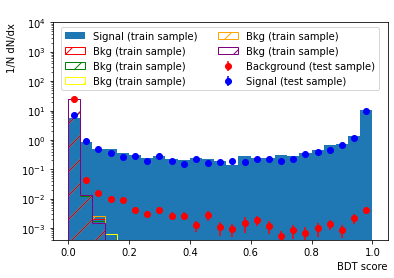

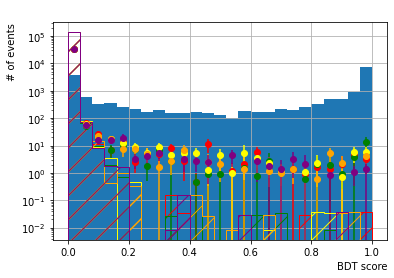

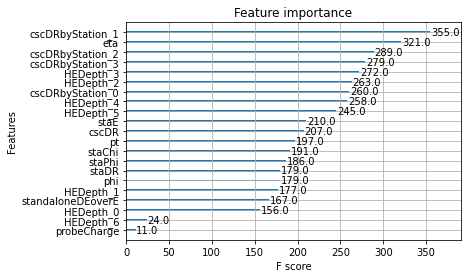

DEBUGGING
121023


In [30]:
  curves = []
  importance = []
  sigPreds = []
  newGenPreds = [] 

  bdtArray, array_train, array_test, array_train_array, array_test_array, array_train_lbl, array_test_lbl, array_trainWeight, array_testWeight, array_testMasses, array_SystWeights = kFoldCrossValidation(best_params,missingOneHit,allTrainingFeatures,nFolds,missingOneHit_SystWeights)
#  bdtArray, array_train, array_test, array_train_array, array_test_array, array_train_lbl, array_test_lbl, array_trainWeight, array_testWeight, array_testMasses = kFoldCrossValidation(best_params,filteredData,allTrainingFeatures,nFolds)
  print(len(bdtArray[0].evals_result()))
  print(bdtArray[0].evals_result())
  print("len(array_test_array)")
  print(len(array_test_array))

  sumLogLoss = 0
  for i in range(0,nFolds):
    eval_results = bdtArray[i].evals_result()
    sumLogLoss = sumLogLoss + eval_results['validation_0']['logloss'][len(eval_results['validation_0']['logloss'])-1]
  meanLogLoss = sumLogLoss/nFolds
  print("meanLogLoss")
  print(meanLogLoss)
    
  sumSquaredLogLoss = 0
  for i in range(0,nFolds): 
    eval_results = bdtArray[i].evals_result()
    sumSquaredLogLoss = sumSquaredLogLoss + (meanLogLoss - eval_results['validation_0']['logloss'][len(eval_results['validation_0']['logloss'])-1])**2
    
  stdLogLoss = mth.sqrt(sumSquaredLogLoss/nFolds)
  print("stdLogLoss")
  print(stdLogLoss)

  #print(eval_results['validation_0']['logloss'])
  #print(eval_results['validation_0']['logloss'][len(eval_results['validation_0']['logloss'])-1])
  #for key, value in eval_results['validation_0'].items():
  #      print(key, value)

  haveAll_x,haveAll_y,haveAll_masses = format_data(haveAll,allTrainingFeatures)
  haveAll_weights = haveAll_x[:,haveAll_x.shape[1]-1]
  haveAll_x = np.delete(haveAll_x,haveAll_x.shape[1]-1,1)            

  haveAll_pred = []
  for i in range(0,nFolds):
    haveAll_pred.append(bdtArray[i].predict(haveAll_x))
#    print("BDT i")
#    print (i)
#    for j in range(0,len(haveAll_pred[i])):
#        print(j)
#        print(haveAll_pred[i][j])


  print("Number of haveAll events")
  print(len(haveAll_pred[0]))
  haveAll_y = haveAll_y.flatten()
  print(haveAll_y)
  print(haveAll_weights)
  nBkg_haveAll = 0
  for i in range(0,len(haveAll_pred[0])):
    if haveAll_y[i] == 0: nBkg_haveAll = nBkg_haveAll + 1
    
  print(nBkg_haveAll)
    
  y_preds, labels, weights, masses_labels, testEvents_array, BDToutput_systWeights = combiningKFolds(bdtArray,array_test,array_test_array,array_testWeight,array_testMasses,array_train,array_train_array,array_trainWeight,nFolds, array_SystWeights)

  print(len(BDToutput_systWeights))
  print("DEBUG")
  print(len(testEvents_array))
  print(len(y_preds))
  print(len(weights))
  print(len(labels))
  nBkg_AllEvents = 0
  for i in range(0,len(y_preds)):
    if labels[i] == 0: nBkg_AllEvents = nBkg_AllEvents + 1
    
  print("Number of Bkg events total")
  print(nBkg_AllEvents)

  fpralt, tpralt, thresholdsalt = roc_curve(labels, y_preds,sample_weight=weights) 

  print("DEBUGGING")
  print(fpralt)
  print(len(fpralt))


##### CHARGE NOT USED IN BDT ######
#  filteredData.drop('probeCharge', inplace=True, axis=1)
#  best_estimator_noC, best_params_noC, train_noC, test_noC, trainWeight_noC, testWeight_noC, raw_pos_weight_noC, train_array_noC, test_array_noC, test_masses_noC = optimize_hyper_xg(filteredData,allTrainingFeatures_noC,1)

#  y_predsAlt_noC = best_estimator_noC.predict(test_array_noC)
#  labelsalt_noC = test_noC.get_label()
#  fpralt_noC, tpralt_noC, thresholdsalt_noC = roc_curve(labelsalt_noC, y_predsAlt_noC,sample_weight=testWeight_noC) 

#  y_predsAltTrain_noC = best_estimator_noC.predict(train_array_noC)
#  labelsaltTrain_noC = train_noC.get_label()    
#####################################
         

  #Using predictions of testing dataset
  bkg_predsAlt = []
  sig0p2_predsAlt = []
  sig0p4_predsAlt = []
  sig0p6_predsAlt = []
  sig0p8_predsAlt = []
  sig1p0_predsAlt = []
#  sig2p0_predsAlt = []   
  for idx2, BDTscore in enumerate(y_preds):
      if labels[idx2] == 0: bkg_predsAlt.append(BDTscore)
      else:
            if masses_labels[idx2] == "0p2": sig0p2_predsAlt.append(BDTscore)
            elif masses_labels[idx2] == "0p4": sig0p4_predsAlt.append(BDTscore)
            elif masses_labels[idx2] == "0p6": sig0p6_predsAlt.append(BDTscore)
            elif masses_labels[idx2] == "0p8": sig0p8_predsAlt.append(BDTscore)
            elif masses_labels[idx2] == "1p0": sig1p0_predsAlt.append(BDTscore)
#            elif masses_labels[idx2] == "2p0": sig2p0_predsAlt.append(BDTscore)

###UNCOMMENT TO PLOT SIGNAL LIKE BACKGROUND EVENTS    
  #plotVariables(sig_SignalLikeEvents, sigMasses, df_bkg_SignalLikeEvents, allTrainingFeatures)    

  #plotOverTraining(y_predsAlt,labelsalt,array_testWeight[0],y_predsAltTrain,labelsaltTrain,array_trainWeight[0],"allVariables")
  #plotOverTraining(y_predsAlt_noC,labelsalt_noC,testWeight_noC,y_predsAltTrain_noC,labelsaltTrain_noC,trainWeight_noC,"noTrackCharge")
    

  newGenPreds.append(bkg_predsAlt)
  ###When using the fixBiasing samples###
  sigPreds.append(sig0p4_predsAlt)
  sigPreds.append(sig0p8_predsAlt)
  sigPreds.append(sig0p6_predsAlt)
  sigPreds.append(sig0p2_predsAlt)
  sigPreds.append(sig1p0_predsAlt)
  ###When using the ecalBrem samples###
  #sigPreds.append(sig0p4_predsAlt)
  #sigPreds.append(sig0p6_predsAlt)
  #sigPreds.append(sig0p2_predsAlt)
  #sigPreds.append(sig0p8_predsAlt)
  #sigPreds.append(sig1p0_predsAlt)    

#  importance.append(xgb.plot_importance(bst))
  importance.append(xgb.plot_importance(bdtArray[0]))
    
  Text_yticklabels = list(importance[0].get_yticklabels())
  dict_features = dict(enumerate(allTrainingFeatures[0:len(allTrainingFeatures)-1]))
  lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
  lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

  importance[0].set_yticklabels(lst_yticklabels)
  print(dict_features)
  plt.show()

  #importance.append(xgb.plot_importance(best_estimator_noC))
    
  #Text_yticklabels = list(importance[1].get_yticklabels())
  #dict_features = dict(enumerate(allTrainingFeatures_noC[0:len(allTrainingFeatures_noC)-1]))
  #lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
  #lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

  #importance[1].set_yticklabels(lst_yticklabels)
  #print(dict_features)
  #plt.show()

  print("DEBUGGING")
  print(len(weights))

  curves.append([fpralt,tpralt,fpralt,tpralt,mceff,sigeff,fpralt,tpralt,mceff,sigeff])

This plots the training variables for the high BDT events

LOOKING FOR SIGNAL LIKE EVENTS
121023
121023
121023
121023
802
0.9901692867279053
3718
0.9987024068832397
7178
0.9905153512954712
21862
0.9545282125473022
24567
0.9955572485923767
30873
0.9917187690734863
33936
0.9880915880203247
34026
0.9884722232818604
35023
0.9774633646011353
37604
0.9955926537513733
43863
0.9955458641052246
58142
0.9690203070640564
62367
0.9989787340164185
66564
0.9966616630554199
67766
0.9756801128387451
73218
0.9987917542457581
82763
0.9712173342704773
83099
0.9933475852012634
83702
0.9915295839309692
92046
0.9611860513687134
109081
0.9974347949028015
Number of background events
21
418
22
[[ 6.05227231e+01  1.84444629e+00  6.04583288e-01 ...  1.26037970e-01
   2.13136643e-01  5.85814642e+00]
 [ 4.15747678e+01 -1.90486154e+00  2.27252340e-01 ... -1.00000000e+00
   5.01318462e-02  5.68128765e+00]
 [ 4.42733539e+01 -1.79011684e+00  1.35231245e+00 ...  4.48774435e-02
   1.48751450e+00  5.49176876e+00]
 ...
 [ 7.86843358e+01  2.14225321e+00  9.68233053e-01 ...  1.4901

/home/auerb029/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


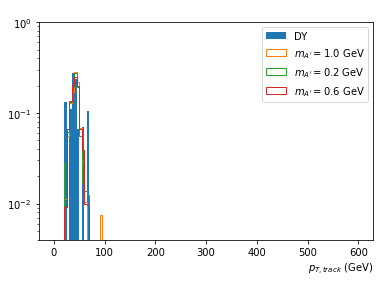

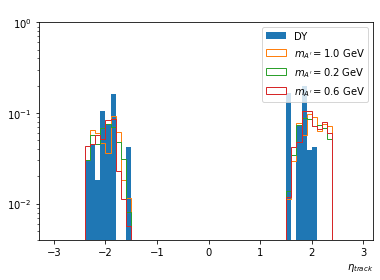

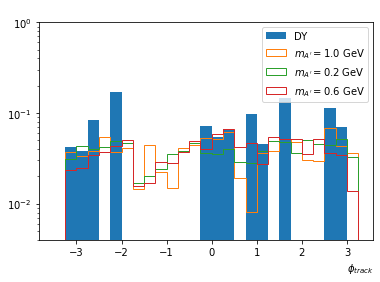

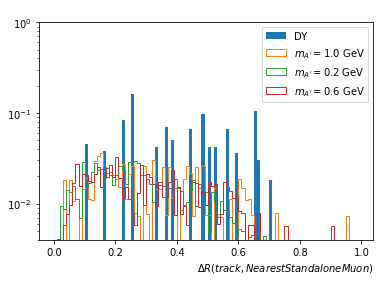

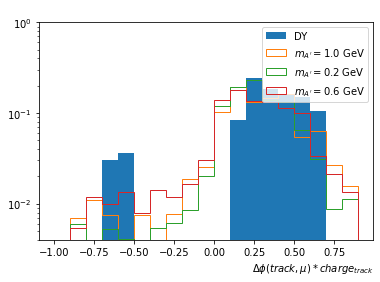

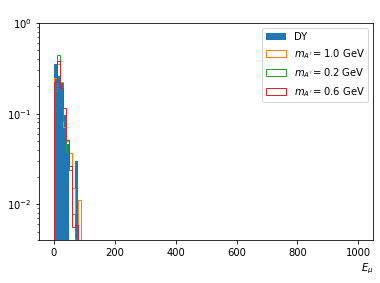

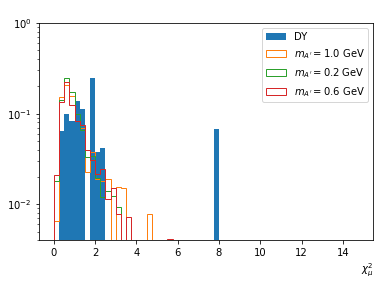

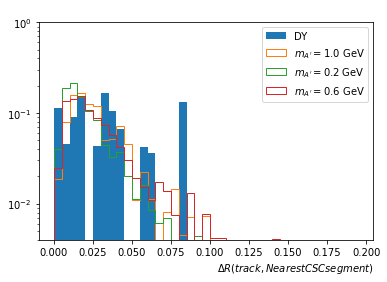

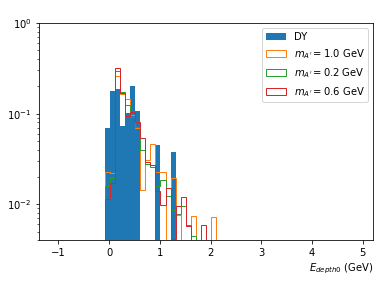

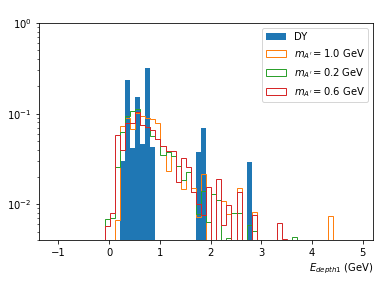

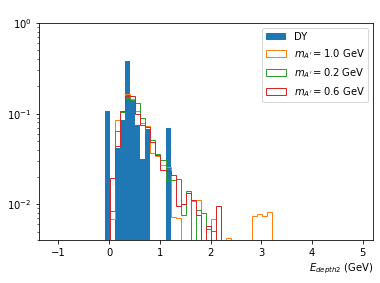

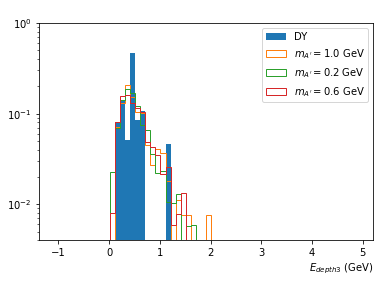

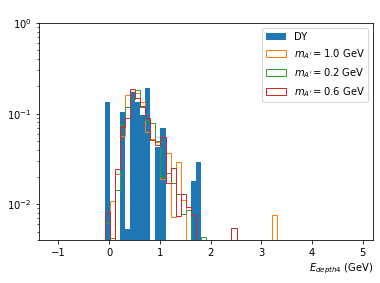

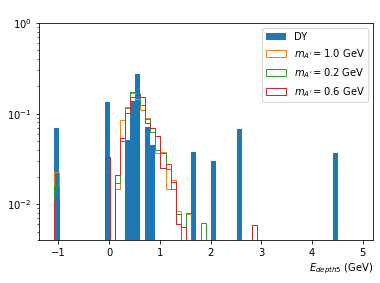

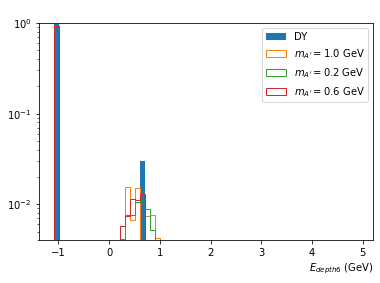

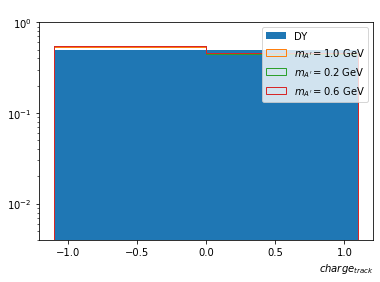

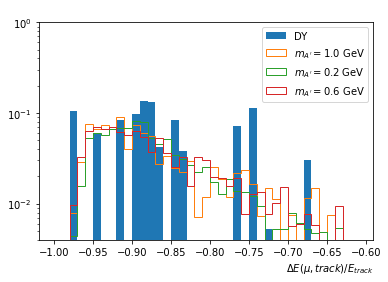

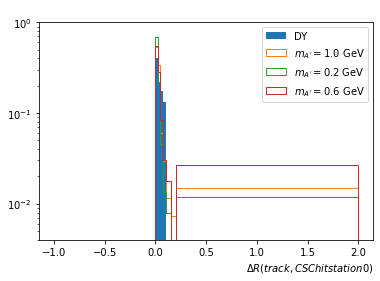

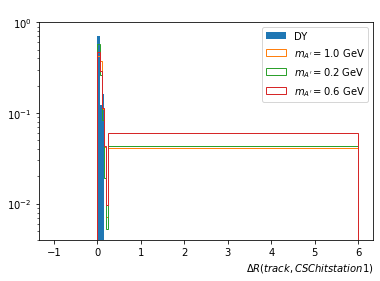

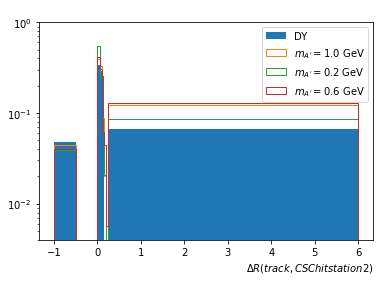

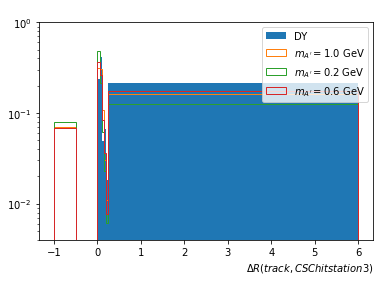

In [31]:
#Plot the signal like events. These are selected in the above cell
  bkg_SignalLikeEvents = []
  sig0p2_SignalLikeEvents = []     
  sig0p4_SignalLikeEvents = []     
  sig0p6_SignalLikeEvents = []     
  sig0p8_SignalLikeEvents = []     
  sig1p0_SignalLikeEvents = []     
#  sig2p0_SignalLikeEvents = []         
  print("LOOKING FOR SIGNAL LIKE EVENTS")    
  print(len(masses_labels))
  print(len(y_preds))
  print(len(testEvents_array))
  print(len(weights))
  for idx2, BDTscore in enumerate(y_preds):
      if BDTscore > 0.95 and labels[idx2]==0:
            print(idx2)
            print(BDTscore)
            bkg_SignalLikeEvents.append(np.concatenate((testEvents_array[idx2],[weights[idx2]])))
      elif BDTscore > 0.95 and labels[idx2]==1:
            if masses_labels[idx2] == "0p2": sig0p2_SignalLikeEvents.append(np.concatenate((testEvents_array[idx2],[weights[idx2]])))
            elif masses_labels[idx2] == "0p4": sig0p4_SignalLikeEvents.append(np.concatenate((testEvents_array[idx2],[weights[idx2]])))
            elif masses_labels[idx2] == "0p6": sig0p6_SignalLikeEvents.append(np.concatenate((testEvents_array[idx2],[weights[idx2]])))
            elif masses_labels[idx2] == "0p8": sig0p8_SignalLikeEvents.append(np.concatenate((testEvents_array[idx2],[weights[idx2]])))
            elif masses_labels[idx2] == "1p0": sig1p0_SignalLikeEvents.append(np.concatenate((testEvents_array[idx2],[weights[idx2]])))
#            elif masses_labels[idx2] == "2p0": sig2p0_SignalLikeEvents.append(np.concatenate((testEvents_array[idx2],[weights[idx2]])))
 
  print("Number of background events")
  print(len(bkg_SignalLikeEvents))
  print(len(sig0p8_SignalLikeEvents))
  np_bkg_SignalLikeEvents = np.array(bkg_SignalLikeEvents)
  np_sig0p2_SignalLikeEvents = np.array(sig0p2_SignalLikeEvents)
  np_sig0p4_SignalLikeEvents = np.array(sig0p4_SignalLikeEvents)
  np_sig0p6_SignalLikeEvents = np.array(sig0p6_SignalLikeEvents)
  np_sig0p8_SignalLikeEvents = np.array(sig0p8_SignalLikeEvents)
  np_sig1p0_SignalLikeEvents = np.array(sig1p0_SignalLikeEvents)
#  np_sig2p0_SignalLikeEvents = np.array(sig2p0_SignalLikeEvents)
  print(len(allTrainingFeatures))
  print(np_sig0p8_SignalLikeEvents)
  df_bkg_SignalLikeEvents = pd.DataFrame(np_bkg_SignalLikeEvents, columns=allTrainingFeatures)
  df_sig0p2_SignalLikeEvents = pd.DataFrame(np_sig0p2_SignalLikeEvents, columns=allTrainingFeatures)
  df_sig0p4_SignalLikeEvents = pd.DataFrame(np_sig0p4_SignalLikeEvents, columns=allTrainingFeatures)
  df_sig0p6_SignalLikeEvents = pd.DataFrame(np_sig0p6_SignalLikeEvents, columns=allTrainingFeatures)
  df_sig0p8_SignalLikeEvents = pd.DataFrame(np_sig0p8_SignalLikeEvents, columns=allTrainingFeatures)
  df_sig1p0_SignalLikeEvents = pd.DataFrame(np_sig1p0_SignalLikeEvents, columns=allTrainingFeatures)
#  df_sig2p0_SignalLikeEvents = pd.DataFrame(np_sig2p0_SignalLikeEvents, columns=allTrainingFeatures)    
    
  sig_SignalLikeEvents = []  
  for mass in sigMasses:
    if mass == "0p2": sig_SignalLikeEvents.append(df_sig0p2_SignalLikeEvents)
    if mass == "0p4": sig_SignalLikeEvents.append(df_sig0p4_SignalLikeEvents)
    if mass == "0p6": sig_SignalLikeEvents.append(df_sig0p6_SignalLikeEvents)
    if mass == "0p8": sig_SignalLikeEvents.append(df_sig0p8_SignalLikeEvents)
    if mass == "1p0": sig_SignalLikeEvents.append(df_sig1p0_SignalLikeEvents)
#    if mass == "2p0": sig_SignalLikeEvents.append(df_sig2p0_SignalLikeEvents)
    
    
  plotVariables(sig_SignalLikeEvents, sigMasses, df_bkg_SignalLikeEvents, allTrainingFeatures)    


BDT results for the same sign MC events. Not used anymore

In [32]:
  stacut = -0.6
  filter = (weightedMcInputs_SameSign['standaloneDEoverE']<stacut) & (weightedMcInputs_SameSign['cellEdgeDeta']>0.004) & (weightedMcInputs_SameSign['cellEdgeDphi']>0.016)
  filteredData = weightedMcInputs_SameSign[filter]

  print(len(filteredData))
  filteredData.drop('cellEdgeDphi', inplace=True, axis=1)
  filteredData.drop('cellEdgeDeta', inplace=True, axis=1)
  missingOneHit_SameSign = filteredData.copy()
 # missingOneHit_SameSign = missingOneHit_SameSign[((missingOneHit_SameSign['HEDepth_0']==0) | (missingOneHit_SameSign['HEDepth_1']==0) | (missingOneHit_SameSign['HEDepth_2']==0) | (missingOneHit_SameSign['HEDepth_3']==0) | (missingOneHit_SameSign['HEDepth_4']==0) | (missingOneHit_SameSign['HEDepth_5']==0) | (missingOneHit_SameSign['HEDepth_6']==0))]

  print(len(missingOneHit_SameSign))
  missingOneHit_SameSign_x,missingOneHit_SameSign_y,missingOneHit_SameSign_massess = format_data(missingOneHit_SameSign,allTrainingFeatures)
  missingOneHit_SameSign_weights = missingOneHit_SameSign_x[:,missingOneHit_SameSign_x.shape[1]-1]
  missingOneHit_SameSign_x = np.delete(missingOneHit_SameSign_x,missingOneHit_SameSign_x.shape[1]-1,1)            

  SameSign_pred = []
  for i in range(0,nFolds):
    SameSign_pred.append(bdtArray[i].predict(missingOneHit_SameSign_x))
  
  print(SameSign_pred)
  np.histogram(SameSign_pred[1],bins=np.arange(0,1.01,0.04))
#  axes = SameSign_pred[0].hist(column='BDTscore',log=True,
#                               bins=np.arange(0,1.01,0.04),
#                               label='Same Sign BDT 0')   

2
2
[array([1.5795511e-03, 3.9329418e-05], dtype=float32), array([1.3794026e-03, 4.5737903e-05], dtype=float32), array([1.6168186e-03, 5.0977891e-05], dtype=float32), array([4.8071812e-03, 2.5163983e-05], dtype=float32), array([1.7758480e-03, 4.7915575e-05], dtype=float32)]


/home/auerb029/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]))

BDT results for the same sign data events. Used to predict the muPX background

In [33]:
  stacut = -0.6
  filter = (dataInputs_SameSign['standaloneDEoverE']<stacut) & (dataInputs_SameSign['cellEdgeDeta']>0.004) & (dataInputs_SameSign['cellEdgeDphi']>0.016)
  filteredData = dataInputs_SameSign[filter]
    
  filteredData.drop('cellEdgeDphi', inplace=True, axis=1)
  filteredData.drop('cellEdgeDeta', inplace=True, axis=1)
  missingOneHit_data_SameSign = filteredData.copy()

  data_SameSign_x,data_SameSign_y,data_SameSign_massess = format_data(missingOneHit_data_SameSign,allTrainingFeatures)
  data_SameSign_weights = data_SameSign_x[:,data_SameSign_x.shape[1]-1]
  data_SameSign_x = np.delete(data_SameSign_x,data_SameSign_x.shape[1]-1,1)            

  SameSign_pred = []
  for i in range(0,nFolds):
    SameSign_pred.append(bdtArray[i].predict(data_SameSign_x))
  
  print(SameSign_pred)
  counts_sameSign, binedges = np.histogram(SameSign_pred[1],bins=np.arange(0,1.01,0.04))
  print(binedges)
  print(counts_sameSign)
 

[array([4.1578518e-04, 9.4950831e-01, 3.0618128e-01, 2.9961565e-01,
       1.3798277e-04, 2.8287966e-04, 1.7061855e-05, 2.0259521e-04,
       8.1926531e-01, 2.2264932e-04, 9.0268031e-03, 2.3812649e-03,
       4.5524157e-05, 5.7936653e-02, 3.1386379e-02, 1.0275650e-01,
       5.2435958e-06, 7.2850869e-03, 9.9318138e-05, 2.4155626e-05,
       3.1652267e-03, 3.9329418e-05, 1.4562090e-04, 2.4158154e-03,
       2.1219043e-04, 1.4603175e-01, 3.2210785e-03, 4.9589060e-05,
       1.7189933e-03, 5.4186648e-03, 1.4059120e-04, 4.8647676e-02,
       9.5314372e-06, 3.7056566e-04, 6.2454354e-05, 2.8724749e-05,
       3.9067823e-03, 8.8905358e-01, 1.9155023e-05, 1.5505435e-04,
       1.4437523e-02, 9.7406459e-01, 9.9816114e-01, 2.5816187e-02,
       2.3716220e-03, 9.9280459e-01, 4.4583739e-04, 8.8559529e-05,
       4.4037759e-02, 2.4643881e-04, 9.9460728e-02], dtype=float32), array([1.6910653e-04, 9.1080737e-01, 9.6030128e-01, 8.0983067e-01,
       3.6249385e-05, 2.8250396e-04, 2.3606406e-05, 1.35603

/home/auerb029/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


BDT prediction of the ECAL Brem signal samples. Manipulates the dataframes in the same way the original 'fixB

In [34]:
  sigPreds_ecalBrem = []
  stacut = -0.6
  filter = (allSignals_ecalBrem['standaloneDEoverE']<stacut) & (allSignals_ecalBrem['cellEdgeDeta']>0.004) & (allSignals_ecalBrem['cellEdgeDphi']>0.016)
  filteredData = allSignals_ecalBrem[filter]
  signal_ecalBrem_SystWeights = filteredData.copy()
    
  filteredData.drop('cellEdgeDphi', inplace=True, axis=1)
  filteredData.drop('cellEdgeDeta', inplace=True, axis=1)
  filteredData.drop(['PUupWeight'],inplace=True, axis=1)    
  filteredData.drop(['PUdownWeight'],inplace=True, axis=1)    
  filteredData.drop(['IDupWeight'],inplace=True, axis=1)    
  filteredData.drop(['IDdownWeight'],inplace=True, axis=1)    
  filteredData.drop(['ISOupWeight'],inplace=True, axis=1)    
  filteredData.drop(['ISOdownWeight'],inplace=True, axis=1)    
  filteredData.drop(['TrigUpWeight'],inplace=True, axis=1)    
  filteredData.drop(['TrigDownWeight'],inplace=True, axis=1)    
  filteredData.drop(['EnBinWeight'],inplace=True, axis=1) 
  filteredData.drop(['EventWeight_cscReweight'],inplace=True, axis=1)     
  print(filteredData)

  signal_ecalBrem_SystWeights.drop(['pt'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['eta'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['phi'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['staDR'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['staPhi'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['staE'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['staChi'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['cscDR'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['HEDepth_0'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['HEDepth_1'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['HEDepth_2'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['HEDepth_3'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['HEDepth_4'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['HEDepth_5'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['HEDepth_6'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['probeCharge'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['standaloneDEoverE'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['cscDRbyStation_0'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['cscDRbyStation_1'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['cscDRbyStation_2'],inplace=True, axis=1)
  signal_ecalBrem_SystWeights.drop(['cscDRbyStation_3'],inplace=True, axis=1)        
    
  signal_ecalBrem_x,signal_ecalBrem_y,signal_ecalBrem_massess = format_data(filteredData,allTrainingFeatures)
  signal_ecalBrem_weights = signal_ecalBrem_x[:,signal_ecalBrem_x.shape[1]-1]
  signal_ecalBrem_x = np.delete(signal_ecalBrem_x,signal_ecalBrem_x.shape[1]-1,1)            

  signal_ecalBrem_pred = []
  for i in range(0,nFolds):
    signal_ecalBrem_pred.append(bdtArray[i].predict(signal_ecalBrem_x))
  
  print(signal_ecalBrem_pred)

  #Using predictions of testing dataset
  sig0p2_ecalBrem_preds = []
  sig0p4_ecalBrem_preds = []
  sig0p6_ecalBrem_preds = []
  sig0p8_ecalBrem_preds = []
  sig1p0_ecalBrem_preds = []
  for idx2, BDTscore in enumerate(signal_ecalBrem_pred[0]):
            if signal_ecalBrem_massess[idx2] == "0p2": sig0p2_ecalBrem_preds.append(BDTscore)
            elif signal_ecalBrem_massess[idx2] == "0p4": sig0p4_ecalBrem_preds.append(BDTscore)
            elif signal_ecalBrem_massess[idx2] == "0p6": sig0p6_ecalBrem_preds.append(BDTscore)
            elif signal_ecalBrem_massess[idx2] == "0p8": sig0p8_ecalBrem_preds.append(BDTscore)
            elif signal_ecalBrem_massess[idx2] == "1p0": sig1p0_ecalBrem_preds.append(BDTscore)
    
  print(len(sig0p2_ecalBrem_preds))
  print(len(sig0p4_ecalBrem_preds))
  print(len(sig0p6_ecalBrem_preds))
  print(len(sig0p8_ecalBrem_preds))
  print(len(sig1p0_ecalBrem_preds))
    
  sigPreds_ecalBrem.append(sig0p4_ecalBrem_preds)
  sigPreds_ecalBrem.append(sig0p8_ecalBrem_preds)
  sigPreds_ecalBrem.append(sig0p6_ecalBrem_preds)
  sigPreds_ecalBrem.append(sig0p2_ecalBrem_preds)
  sigPreds_ecalBrem.append(sig1p0_ecalBrem_preds)    
 
  #sigPreds_ecalBrem.append(sig0p4_ecalBrem_preds)
  #sigPreds_ecalBrem.append(sig0p6_ecalBrem_preds)
  #sigPreds_ecalBrem.append(sig0p2_ecalBrem_preds)
  #sigPreds_ecalBrem.append(sig0p8_ecalBrem_preds)
  #sigPreds_ecalBrem.append(sig1p0_ecalBrem_preds)        

             pt       eta       phi     staDR    staPhi       staE    staChi  \
3     22.606206  1.826906  2.795987  0.144784  0.143345  24.585039  0.699720   
4     38.194523 -1.531403  0.012736  0.073803  0.068990  32.210991  1.311674   
10    53.071333 -1.814733 -2.726713  0.099305  0.099305  42.618290  0.867414   
15    39.151675  2.258407  0.564943  0.062029  0.061994  59.205925  1.085261   
17    64.749175  1.979999 -1.082606  0.228879  0.225149  18.882063  0.475454   
...         ...       ...       ...       ...       ...        ...       ...   
2162  63.331839 -1.685170  1.205026  0.470551  0.433311  12.326267  0.970043   
2166  45.295424 -2.376170  0.066610  0.240156 -0.239520  51.273903  2.210646   
2172  51.356867 -2.025153  1.417660  0.308580  0.307861  14.410240  2.028878   
2183  49.099254  1.753725 -0.011566  0.088359  0.087869  22.120260  0.607338   
2184  41.769768  2.199099  2.933110  0.448426  0.445270   6.865371  0.539110   

         cscDR  HEDepth_0  HEDepth_1  .

/home/auerb029/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[array([7.7395178e-03, 2.1621067e-02, 8.7826996e-04, ..., 9.8087960e-01,
       9.9926478e-01, 9.8986501e-01], dtype=float32), array([1.5707800e-02, 1.0748864e-02, 9.8668295e-04, ..., 9.9092418e-01,
       9.9959201e-01, 9.9458545e-01], dtype=float32), array([0.00885887, 0.00522043, 0.00126722, ..., 0.9640097 , 0.9998636 ,
       0.9884322 ], dtype=float32), array([0.03540973, 0.00570914, 0.00699974, ..., 0.95902544, 0.9994854 ,
       0.9687594 ], dtype=float32), array([0.02005556, 0.01953474, 0.00201642, ..., 0.9772331 , 0.99883646,
       0.98395544], dtype=float32)]
4614
2223
1096
796
469


/home/auerb029/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/auerb029/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


20
20
[291.41379514360676, 52.40229002629561, 34.292856398964496, 28.231188426986208, 23.664319132398465, 21.748563170931547, 20.518284528683193, 18.027756377319946, 17.916472867168917, 18.193405398660254, 17.146428199482248, 16.852299546352718, 15.329709716755891, 16.217274740226856, 14.933184523068078, 16.73320053068151, 17.0, 18.547236990991408, 21.72556098240043, 36.959437225152655]


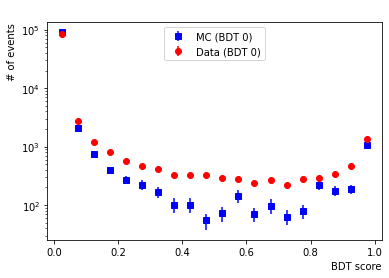

In [35]:
  stacut = -0.6
  filter = (weightedMCInputs_highHCAL['standaloneDEoverE']<100) 
  filteredMC = weightedMCInputs_highHCAL[filter]    
  filteredMC.drop('cellEdgeDphi', inplace=True, axis=1)
  filteredMC.drop('cellEdgeDeta', inplace=True, axis=1)
  missingOneHit_highHCAL = filteredMC.copy()

  filter = (dataInputs_highHCAL['standaloneDEoverE']<100)
  filteredData = dataInputs_highHCAL[filter]
  filteredData.drop('cellEdgeDphi', inplace=True, axis=1)
  filteredData.drop('cellEdgeDeta', inplace=True, axis=1)
  missingOneHitData_highHCAL = filteredData.copy()

  missingOneHit_highHCAL_x,missingOneHit_highHCAL_y,missingOneHit_highHCAL_massess = format_data(missingOneHit_highHCAL,allTrainingFeatures)
  missingOneHit_highHCAL_weights = missingOneHit_highHCAL_x[:,missingOneHit_highHCAL_x.shape[1]-1]
  missingOneHit_highHCAL_x = np.delete(missingOneHit_highHCAL_x,missingOneHit_highHCAL_x.shape[1]-1,1)            

  missingOneHitData_highHCAL_x,missingOneHitData_highHCAL_y,missingOneHitData_highHCAL_massess = format_data(missingOneHitData_highHCAL,allTrainingFeatures)
  missingOneHitData_highHCAL_weights = missingOneHitData_highHCAL_x[:,missingOneHitData_highHCAL_x.shape[1]-1]
  missingOneHitData_highHCAL_x = np.delete(missingOneHitData_highHCAL_x,missingOneHitData_highHCAL_x.shape[1]-1,1)  
    
  MC_highHCAL_pred = []
  Data_highHCAL_pred = []
  for i in range(0,nFolds):
    MC_highHCAL_pred.append(bdtArray[i].predict(missingOneHit_highHCAL_x))
    Data_highHCAL_pred.append(bdtArray[i].predict(missingOneHitData_highHCAL_x))
    
  pd_MC_highHCAL_pred = pd.DataFrame({'BDTscore':MC_highHCAL_pred[0],'eventWeights':missingOneHit_highHCAL_weights}) 

  MC_highHCAL_Weights = pd_MC_highHCAL_pred['eventWeights']
  MC_highHCAL_Weights_unity = MC_highHCAL_Weights/(MC_highHCAL_Weights.sum())
  
  pd_Data_highHCAL_pred = pd.DataFrame({'BDTscore':Data_highHCAL_pred[0]})
#  pd_Data_highHCAL_pred.hist(column='BDTscore',log=True,
#                             ax=axes,histtype='step',hatch='/', edgecolor="Red",                             
#                             bins=np.arange(0,1.01,0.04),label='Data (BDT 0)')

  bin_edges = np.arange(0,1.04,0.05)         
  bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.  
  #axes.errorbars(bin_centers, )
        
  
  np_Data_highHCAL_pred = pd_Data_highHCAL_pred.to_numpy()
  counts_data, binedges = np.histogram(np_Data_highHCAL_pred[:,0], bins=bin_edges)
  np_counts_data = np.asarray(counts_data)
  #counts_bkg_sqrt = np.sqrt(np_counts_bkg)/(testBkgWeights.sum()*0.04)
    
  counts_data_sqrt = []
  totalCounts = 0
  for counts in counts_data:
    error = np.sqrt(counts)
    counts_data_sqrt.append(error)
    totalCounts = totalCounts + counts
    
  print(len(counts_data))
  print(len(counts_data_sqrt))
  print(counts_data_sqrt)

  np_MC_highHCAL_pred = pd_MC_highHCAL_pred.to_numpy()
  counts_MC, binedges = np.histogram(np_MC_highHCAL_pred[:,0], bins=bin_edges,weights=MC_highHCAL_Weights_unity*totalCounts)
#  counts_MC, binedges = np.histogram(np_MC_highHCAL_pred[:,0], bins=bin_edges,weights=MC_highHCAL_Weights)
  np_counts_MC = np.asarray(counts_MC)
    
  counts_MC_sqrt = []
  for bin_index in range(len(binedges) - 1):  
    bin_left = binedges[bin_index]
    bin_right = binedges[bin_index + 1]
    in_bin = np.logical_and(bin_left < np_MC_highHCAL_pred[:,0], np_MC_highHCAL_pred[:,0] <= bin_right)

    # filter the weights to only those inside the bin
    weights_in_bin = MC_highHCAL_Weights_unity[in_bin]*totalCounts
#    weights_in_bin = MC_highHCAL_Weights[in_bin]

    # compute the error however you want
    error = np.sqrt(np.sum(weights_in_bin ** 2))
    counts_MC_sqrt.append(error)



  plt.errorbar(bin_centers, counts_MC, yerr=counts_MC_sqrt, fmt='s', ecolor='Blue',
               mfc='Blue',mec='Blue',label='MC (BDT 0)')

#  axes = pd_MC_highHCAL_pred.hist(column='BDTscore',log=True,
#                                    bins=np.arange(0,1.04,0.05),
#                                    weights=MC_highHCAL_Weights_unity*totalCounts,
                                    #weights=pd_MC_highHCAL_pred['eventWeights']*59.8*398*1000*1.18*10**(-6),
#                                    label='MC (BDT 0)')


  plt.errorbar(bin_centers, counts_data, yerr=counts_data_sqrt, fmt='o', ecolor='Red',
               mfc='Red',mec='Red',label='Data (BDT 0)')

  plt.xlabel("BDT score", loc='right')
  plt.ylabel("# of events", loc='top')   
  plt.legend(loc='upper center')#,ncol=2)
  plt.grid(False)    
  plt.yscale("log")    
  plt.title(" ")
  plt.savefig("BDT_highHCALE.pdf")    

Plot the ROC curves for each of the test BDTs. Multiplies the false and true positive rates by the standalone muon selection efficiency so that the curve is made for the whole dataset to allow for proper comparisons to the cut-based approach.

0
1p0
truePos
[array([0.02358824], dtype=float32), array([0.00151629], dtype=float32), array([0.00049356], dtype=float32), array([0.02602536], dtype=float32), array([0.01575314], dtype=float32), array([0.03593153], dtype=float32), array([0.00103203], dtype=float32), array([0.03331909], dtype=float32), array([0.00066869], dtype=float32), array([0.00093314], dtype=float32)]


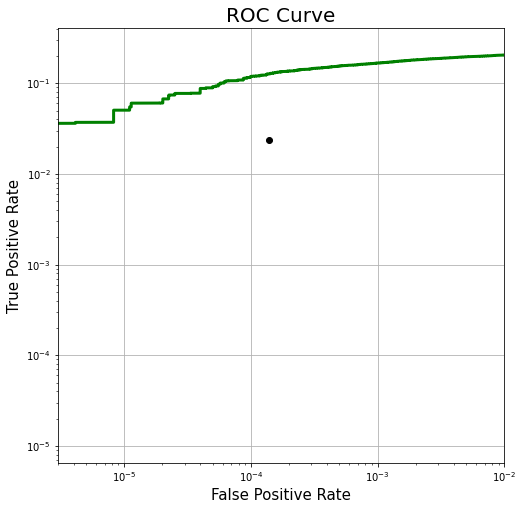

In [36]:
for idx, curve in enumerate(curves):
   print(idx)
   print(sigMasses[idx])
   fig = plt.figure(figsize = (8,8))
   ax = fig.add_subplot(1,1,1)
   ax.set_xlabel('False Positive Rate', fontsize = 15)
   ax.set_ylabel('True Positive Rate', fontsize = 15)
   ax.set_title('ROC Curve', fontsize = 20)
#   ax.set_title('ROC Curve, '+sigMasses[idx], fontsize = 20)
   fpr = curve[0]
   tpr = curve[1]
   fpralt = curve[2]*curve[4]
   tpralt = curve[3]*curve[5]
   fpralt_noC = curve[6]*curve[8]
   tpralt_noC = curve[7]*curve[9]
   xvar = fpr*curve[4]
   yvar = tpr*curve[5]
   #ax.plot(xvar, yvar, '-o',linewidth=3,markersize=0) 
   ax.plot(fpralt,tpralt, '-go',linewidth=3,markersize=0)
#   ax.plot(fpralt_noC,tpralt_noC, '-ro',linewidth=3,markersize=0)
   print("truePos")
   print(truePos)
   ax.plot(falsePos,truePos[idx],'ko')
   ax.grid()
   ax.set_xscale('log')
   ax.set_yscale('log')    
#   ax.legend(['BDT','BDT (no track charge)','Cut Based Estimate'])
#   ax.legend(['Scale POS Weight '+str(pos_weight),'Cut Based Estimate'])
#   ax.legend(['Logistic Regression','Scale POS Weight '+str(pos_weight),'No HE Information','Cut Based Estimate'])
   plt.xlim(0.000003,0.01)
   fig.savefig("partialRegionBDTRocCurve.pdf")

   ax = importance[idx]
   fig = ax.figure
   fig.tight_layout()
   fig.savefig("partialBDTImportance.pdf")

   #ax1 = importance[idx+1]
   #fig1 = ax1.figure
   #fig1.tight_layout()
   #fig1.savefig("partialBDTImportance_noTrackCharge.pdf")

This part makes the dictionaries for my combine input maker. I had trouble making root files with jupyter lab (the python versions are incompatible, so I'd need to switch to a CERN made version of jupyter) so this writes the BDT prediction for each DY and signal point along with the corresponding weights directly to a pickle file, which I load in and then iterate over to fill a histogram in my combine input producer. Maybe more efficient to just used the saved BDTs to re-make the predictions in the other script, but as the file sizes aren't too big and I already have the predictions I did it this way. I also considered just saving the bin edges and counts, but getting the uncertainties correct is a bit of a pain that way.

The file is structured as a list of dictionaries. The first six dictionaries each correspond to a signal mass, and have the mass, standalone muon selection efficiency, DY predictions, signal predictions, and systematic variations for the signal events at that mass.
The final dictionary contains the event weights for the DY samples with each systematic variation, mainly so that the same information isn't repeated in every signal dictionary. 

In [37]:
outputDicts=[]
DY_BDToutput_systWeights = BDToutput_systWeights[BDToutput_systWeights['label']<0.5]
DY_BDToutput_systWeights.drop('label', inplace=True, axis=1)
DY_BDToutput_systWeights.drop('massPoint', inplace=True, axis=1)
print(len(newGenPreds[0]))
print(len(sigPreds))
print(len(curves))
print(len(DY_BDToutput_systWeights))
for idx, mass in enumerate(sigMasses):
    print(idx)
    print(mass)
    sigSplitSystWeights = BDToutput_systWeights[BDToutput_systWeights['massPoint']==mass]
    sigSplitSystWeights.drop(['label'], inplace=True, axis=1)
    sigSplitSystWeights_ecalBrem = signal_ecalBrem_SystWeights[signal_ecalBrem_SystWeights['massPoint']==mass]
    sigSplitSystWeights_ecalBrem.drop(['label'], inplace=True, axis=1)
    massDict = {}
    massDict['name']=mass
#    massDict['dyEff']=curves[0][8]
#    massDict['sigEff']=curves[0][9]
#    massDict['mcPreds']=newGenPreds[1]
#    massDict['sigPreds']=sigPreds[idx+6]
    massDict['dyEff']=curves[0][4]
    massDict['sigEff']=curves[0][5]    
    massDict['mcPreds']=newGenPreds[0]
    massDict['sigPreds']=sigPreds[idx]
    massDict['muPXPreds']=SameSign_pred[0]
    print(len(sigPreds_ecalBrem[idx]))
    massDict['sigPreds_ecalBrem']=sigPreds_ecalBrem[idx]    
    print("len(sigPreds[idx])")
    print(len(sigPreds[idx]))
    print(len(sigSplitSystWeights))
    print(len(sigPreds_ecalBrem[idx]))
    print(len(sigSplitSystWeights_ecalBrem))
    for name, Systweights in sigSplitSystWeights.iteritems():
        massDict[name]=Systweights.values
    for name, Systweights in sigSplitSystWeights_ecalBrem.iteritems():
        massDict[name+'_ecalBrem']=Systweights.values        
    outputDicts.append(massDict)        
dyWeightsDict={}
for name,Systweights in DY_BDToutput_systWeights.iteritems():
    dyWeightsDict[name]=Systweights.values
print(len(dyWeightsDict))
outputDicts.append(dyWeightsDict)
pickle.dump(outputDicts, open('bdtPredictions'+sigMasses[4]+'.pkl', 'wb'),protocol=2)

/home/auerb029/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


111858
5
1
111858
0
1p0
2223
len(sigPreds[idx])
2259
556
2223
469
1
0p2
796
len(sigPreds[idx])
829
4384
796
4614
2
0p4
1096
len(sigPreds[idx])
1137
2259
1096
2223
3
0p6
4614
len(sigPreds[idx])
4384
1137
4614
1096
4
0p8
469
len(sigPreds[idx])
556
829
469
796
12
